# Assess the influence of the temporal irreversiblity on random runs for 10000 years

- using regional volume projections with random climate after year 2500 
    - creates suppl. figures ... 4_only_global_reversibility .... (+ variants)
    - creates RGI19_crazy_tipping_point_glaciers... 
         - e.g. potential mass-balance elevation feedback on single glaciers

In [1]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
import json
import oggm
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
# get the correct colors for the different scenarios
from analysis_func import color_scenario, label_scenario, provide_reg_full_name_dict, color_scenario_poster

palette = sns.color_palette(color_scenario.values())
scenarios = color_scenario.keys()

In [2]:
bc = 'bc_1980_2019' # 'bc_2000_2019' #x #
var = 'temp_21yr_avg'

pd_clim_all = pd.read_csv('../data/annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', index_col = 'Unnamed: 0')

color_scenario_r = {}
color_scenario_r['initial state: stab_T15 after 500 years'] = color_scenario['stab_T15']
color_scenario_r['initial state: oversh_T30OS15 after 500 years'] = color_scenario['oversh_T30OS15']
# color_scenario_r['initial state: zero after 500 years'] = 'black'

palette = sns.color_palette(color_scenario_r.values())



In [3]:
# this is the dataset with the same amount of common running glaciers by just using the for the first part 
df_scenario_usual = xr.open_dataset(f'../data/common_running_of_random_runs_sum_all_rgi_reg_oversh_stab_2000_2500_{bc}.nc').volume

_df_scenario = xr.open_dataset(f'../data/common_running_random_climate_stab_T15_sum_all_rgi_reg_oversh_stab_{bc}.nc')



In [14]:
_df_scenario_sel = _df_scenario.sel(scenario=['initial state: oversh_T30OS15 after 500 years',
                           'initial state: stab_T15 after 500 years']).volume
_df_scenario_sel.coords['time'] = _df_scenario_sel.coords['time']+2500
_df_scenario_sel.coords['scenario'] = ['oversh_T30OS15',
                           'stab_T15']
_df_scenario_sel.coords['gcm'] = ['GFDL-ESM2M']

In [15]:
df_all = xr.concat([df_scenario_usual.sel(scenario=_df_scenario_sel.scenario), _df_scenario_sel], dim='time')

In [24]:
roll_avg = 1

pd_vol_scenario_rel_all = (100*df_all/(df_all.sel(scenario='stab_T15').sel(time=2020).squeeze())).rolling(time=roll_avg, center=True).mean().dropna(dim='time',how='all').to_dataframe('volume_rel_2020_%').reset_index()
pd_vol_scenario_rel_glob_all = (100*df_all.sum(dim='rgi_reg').squeeze()/df_all.sum(dim='rgi_reg').sel(scenario='stab_T15').sel(time=2020).squeeze()).rolling(time=roll_avg, center=True).mean().dropna(dim='time',how='all').to_dataframe('volume_rel_2020_%').reset_index()
#pd_vol_scenario_glob = (100*df_scenario_glob.volume/(df_scenario_usual.sum(dim='provide_region').sel(scenario='stab_T15').sel(time=2020).values)).to_dataframe('volume_rel_2020_%').reset_index()
pd_vol_scenario_rel_glob_all.index = pd_vol_scenario_rel_glob_all.time
pd_vol_scenario_rel_all.index = pd_vol_scenario_rel_all.time

**Check how much % glacier loss occurs beyond 2500 for the stab 15 scenario**

In [25]:
_sel_2500 = pd_vol_scenario_rel_glob_all.loc[2500]
_sel_final = pd_vol_scenario_rel_glob_all.loc[10000]
_sel_2500.loc[_sel_2500.scenario=='stab_T15','volume_rel_2020_%'].values - _sel_final.loc[_sel_final.scenario=='stab_T15','volume_rel_2020_%'].values

array([6.0044975, 6.0044975], dtype=float32)

2252.0 16.057640075683594


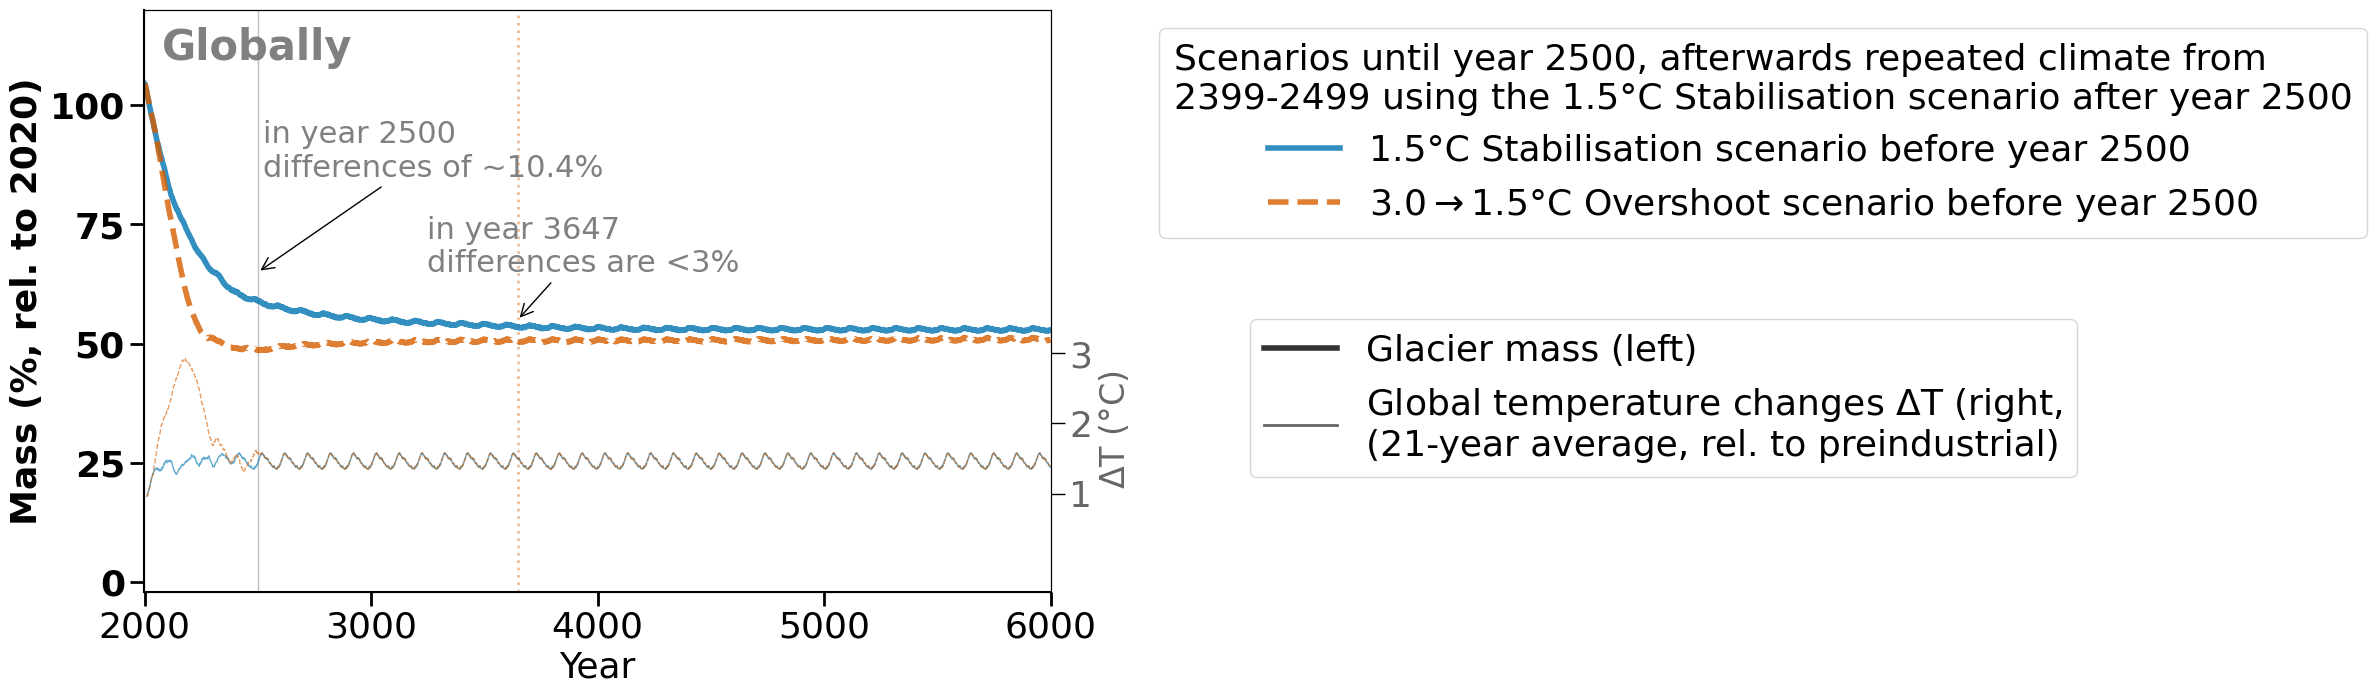

In [28]:
show_temp = True
if not show_temp:
    add = '_no_temp'
else:
    add = ''
    
if show_temp:
    alpha_temp = 1
    alpha_temp2 = 0.6
    width=1
    length=10
else:
    alpha_temp = 0
    alpha_temp2 = 0
    width=0
    length=10
    
show_global_temp = True
if show_global_temp:
    add = '_global_temp'


plt.rc('font', size=26)
portrait = True

plot_vlines = True


for a,color_scenarios in zip(['_all'],
                       [color_scenario_r]):
    #scenarios = color_scenarios.keys()
    scenarios = [ 'stab_T15', 'oversh_T30OS15']
    paletti = list(color_scenarios.values()) #[:-1]  
    if portrait:
        plt.figure(figsize=(42,28)) #, sharey=True, sharex=True)
        plt.subplot(4,4,1)
    else:
        plt.figure(figsize=(45,16)) #, sharey=True, sharex=True)
        plt.subplot(2,7,1)
    ax = plt.gca()
    #ax.set_title('Globally')
    plt.text(0.02,0.97, 'Globally',
             transform=ax.transAxes,ha='left',va='top',
             weight='bold',
             color='grey', fontsize=30)
    ax.set_ylabel('Mass (%, rel. to 2020)', weight='bold')
    sns.lineplot(data=pd_vol_scenario_rel_glob_all.loc[(pd_vol_scenario_rel_glob_all.bias_correction=='bc_1980_2019')&
                                                      (pd_vol_scenario_rel_glob_all.scenario!='oversh_T30OS15')],
                 x='time', y= 'volume_rel_2020_%', 
                 color=paletti[0],
                 label='stab',
                 ls='-',
                 #palette=paletti,
                 #hue_order=scenarios,
                 lw=4, legend=True, alpha=0.8,
                 ax = ax)
    sns.lineplot(data=pd_vol_scenario_rel_glob_all.loc[(pd_vol_scenario_rel_glob_all.bias_correction=='bc_1980_2019')&
                                                      (pd_vol_scenario_rel_glob_all.scenario=='oversh_T30OS15')],
                 x='time', y= 'volume_rel_2020_%', 
                 color=paletti[1],
                 label='oversh',
                 ls='--',
                 #palette=paletti,
                 #hue_order=scenarios,
                 lw=4, legend=True, alpha=0.8,
                 ax = ax)
    #ax.set_xlabel('Year')
    #ax.grid(axis='x')
    ax.set_ylim([-2,120]);
    ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')

    for axis in 'left', 'bottom':
        ax.spines[axis].set_linewidth(1.5)

    # set the parameters for both axis: label size in font points, the line tick line 
    # width and length in pixels
    ax.tick_params(axis='both', which='major', width=2, length=10)
    
    ax.set_xlabel('')
    #ax.set_xlim([2000,2500])
    #ax2.set_xlim([2000,2500])
    plt.axvline(2500, color='grey', zorder=-1, lw=1, alpha = 0.5)
    if plot_vlines:
        #for scenario in df_scenario.scenario.values:
        for scenario in ['initial state: oversh_T30OS15 after 500 years']:
            _p_sel = pd_vol_scenario_rel_glob_all#.loc[pd_vol_scenario_rel_glob_all.provide_region == Preg]
            _p_sel.index = _p_sel.time
            _p_sel = _p_sel.loc[_p_sel.scenario == 'stab_T15']['volume_rel_2020_%'] - _p_sel.loc[_p_sel.scenario == 'oversh_T30OS15']['volume_rel_2020_%']
            print(_p_sel.idxmax(), _p_sel.max())
            _p_sel = _p_sel.loc[2499:]
            yr = _p_sel.loc[_p_sel<3].index.min()
            
            plt.axvline(yr,ls=':', alpha = 0.4, lw=2, 
                       color=color_scenario_r[scenario], zorder=-1)
            if 'oversh' in scenario:
                plt.annotate(xy=(yr, 55),
                             xytext=(yr-400,65), text=f'in year {int(yr)}\ndifferences are <3%',
                             color='grey',arrowprops={'arrowstyle':'->'}, fontsize=22)
                _diff = _p_sel.loc[2499].round(1) # use 2499
                plt.annotate(xy=(2500, 65),
                             xytext=(2500+20,85), text=f'in year 2500\ndifferences of ~{_diff:0.1f}%',
                             color='grey',arrowprops={'arrowstyle':'->'}, fontsize=22)
    ax.set_xlabel('Year')

    ax2 = ax.twinx()  
    for scenario in scenarios:
        
        if show_global_temp:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            _p_sel2 = pd_clim_all.loc[pd_clim_all.region=='global']
            _p_sel2 = _p_sel2.loc[_p_sel2.scenario == 'stab_T15']
            _p_sel2.index = _p_sel2.year
            _p_sel = _p_sel2.loc[2399:2500]['temp']
            _temp_vals = np.tile(_p_sel.values, 50)
            pd_temp_vals = pd.DataFrame(index=np.arange(2000,len(_temp_vals)+2500,1))
            pd_temp_vals.loc[2500:, 'temp'] = _temp_vals
            pd_temp_vals.loc[2000:2499, 'temp'] = pd_clim_scenario_g.loc[2000:2499]['temp'].values
            pd_temp_vals = pd_temp_vals.rolling(21, center=True, min_periods=21).mean()
            pd_clim_scenario_g_ref = pd_clim_scenario_g.loc[1986:2005]['temp'].mean()

            var_g_to_ref = pd_temp_vals['temp']- pd_clim_scenario_g_ref + 0.63
            if 'oversh' in scenario:
                ls = '--'
            else:
                ls = '-'
            ax2.plot(pd_temp_vals.index,#pd_clim_scenario_g.year,
                var_g_to_ref, alpha = alpha_temp2, 
                ls = ls,
                 lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
        else:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            _p_sel2 = pd_clim_all.loc[pd_clim_all.region=='global_glacier']
            _p_sel2 = _p_sel2.loc[_p_sel2.scenario == 'stab_T15']
            _p_sel2.index = _p_sel2.year
            _p_sel = _p_sel2.loc[2399:2500]['temp']
            _temp_vals = np.tile(_p_sel.values, 50)
            pd_temp_vals = pd.DataFrame(index=np.arange(2000,len(_temp_vals)+2500,1))
            pd_temp_vals.loc[2500:, 'temp'] = _temp_vals
            pd_temp_vals.loc[2000:2499, 'temp'] = pd_clim_scenario_g.loc[2000:2499]['temp'].values
            pd_temp_vals = pd_temp_vals.rolling(21, center=True, min_periods=21).mean()

            var_g_to_ref =pd_temp_vals['temp'] - temp_ref_g
            ax2.plot(pd_temp_vals.index,
                     var_g_to_ref,
                     alpha = alpha_temp2, 
                     ls = '-',
                     lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
    if show_global_temp:
        ax2.set_yticks(ticks=[1,2,3],
                       labels=[1,2,3], alpha=alpha_temp2)
        ax2.set_ylim([-0.4,7.9]);
    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                       labels=[0,1,2,3,4,5], alpha=alpha_temp2)
        ax2.set_ylim([-0.4,7.9]);

    #plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
    #ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=width, length=length, grid_alpha =alpha_temp2)
    handles_2, labels_2_nice = ax2.get_legend_handles_labels()
    
    if show_global_temp:
        ax2.set_ylabel(r'$\Delta$T (°C)                         ', #                    '+'\n(vs. pre-industrial)         $_{global}$      ',
                                      alpha = alpha_temp2, fontsize=24)
    else:
        ax2.set_ylabel(r'$\Delta$T'+'(°C) relative to 2000-2019\n(glacier-area weighted)',
                                  alpha = alpha_temp2, fontsize=24)
    ax.set_xlim([1995,6000])
    ax2.set_xlim([1995,6000])

    
    han, lab = ax.get_legend_handles_labels()
    lab[0] = '1.5°C Stabilisation scenario before year 2500'
    lab[1] = r'3.0$\rightarrow$1.5°C Overshoot scenario before year 2500'
    #lab[2] = 'initial state with zero volume'
    ax.legend().remove()

    handles_2, labels_2 = ax2.get_legend_handles_labels()


    plt.tight_layout()
    leg = ax.legend(han, lab, loc = 'upper left',
                    bbox_to_anchor=(1.1,1), 
                    title='Scenarios until year 2500, afterwards repeated climate from\n2399-2499 using the 1.5°C Stabilisation scenario after year 2500')
    for l in leg.get_lines():
        l.set_linewidth(4)
        
        
    if show_temp:
        leg2 = ax.legend([han[0], handles_2[0]], ['Glacier mass (left)',
                                                 r'Global temperature changes $\Delta$T (right,' + '\n(21-year average, rel. to preindustrial)'],
                         loc='upper left', ncol=1, fontsize=26,
                        bbox_to_anchor=(1.2,0.5))
        leg2.get_lines()[0].set_linewidth(4)
        leg2.get_lines()[1].set_linewidth(2)
        for l in leg2.get_lines():
            l.set_color('black')
        ax.add_artist(leg)
    #if portrait:
    #    plt.savefig(f'4_provide_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation.pdf')
    plt.savefig(f'../figures/suppl_4_only_global_reversibility_V2_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation{add}.png',
                dpi=300)

    #else:
    #    plt.savefig(f'4_provide_reg_volume_changes_overshoot{a}_{bc}_random_climate_stabilisation.pdf')


*Conclusion*:  The additional failing glacier area when running over a longer time period comes specifically from regions 07, 08, 09 and 19. This explains that when only looking at the common running glaciers from the long steady-state runs, the discrepancies in the year 2500 are 10.4%, while they are 11.3% when using more common running glaciers (the common running glaciers until 2500)... 

In [37]:
df_all.scenario

<xarray.DataArray 'scenario' (scenario: 2)>
array(['oversh_T30OS15', 'stab_T15'], dtype=object)
Coordinates:
  * scenario      (scenario) object 'oversh_T30OS15' 'stab_T15'
    OGGM_version  <U22 'OGGM_v161_gdirs_2023.3'
Attributes:
    description:  used scenario (here overshoot, stabilisation or commitment ...

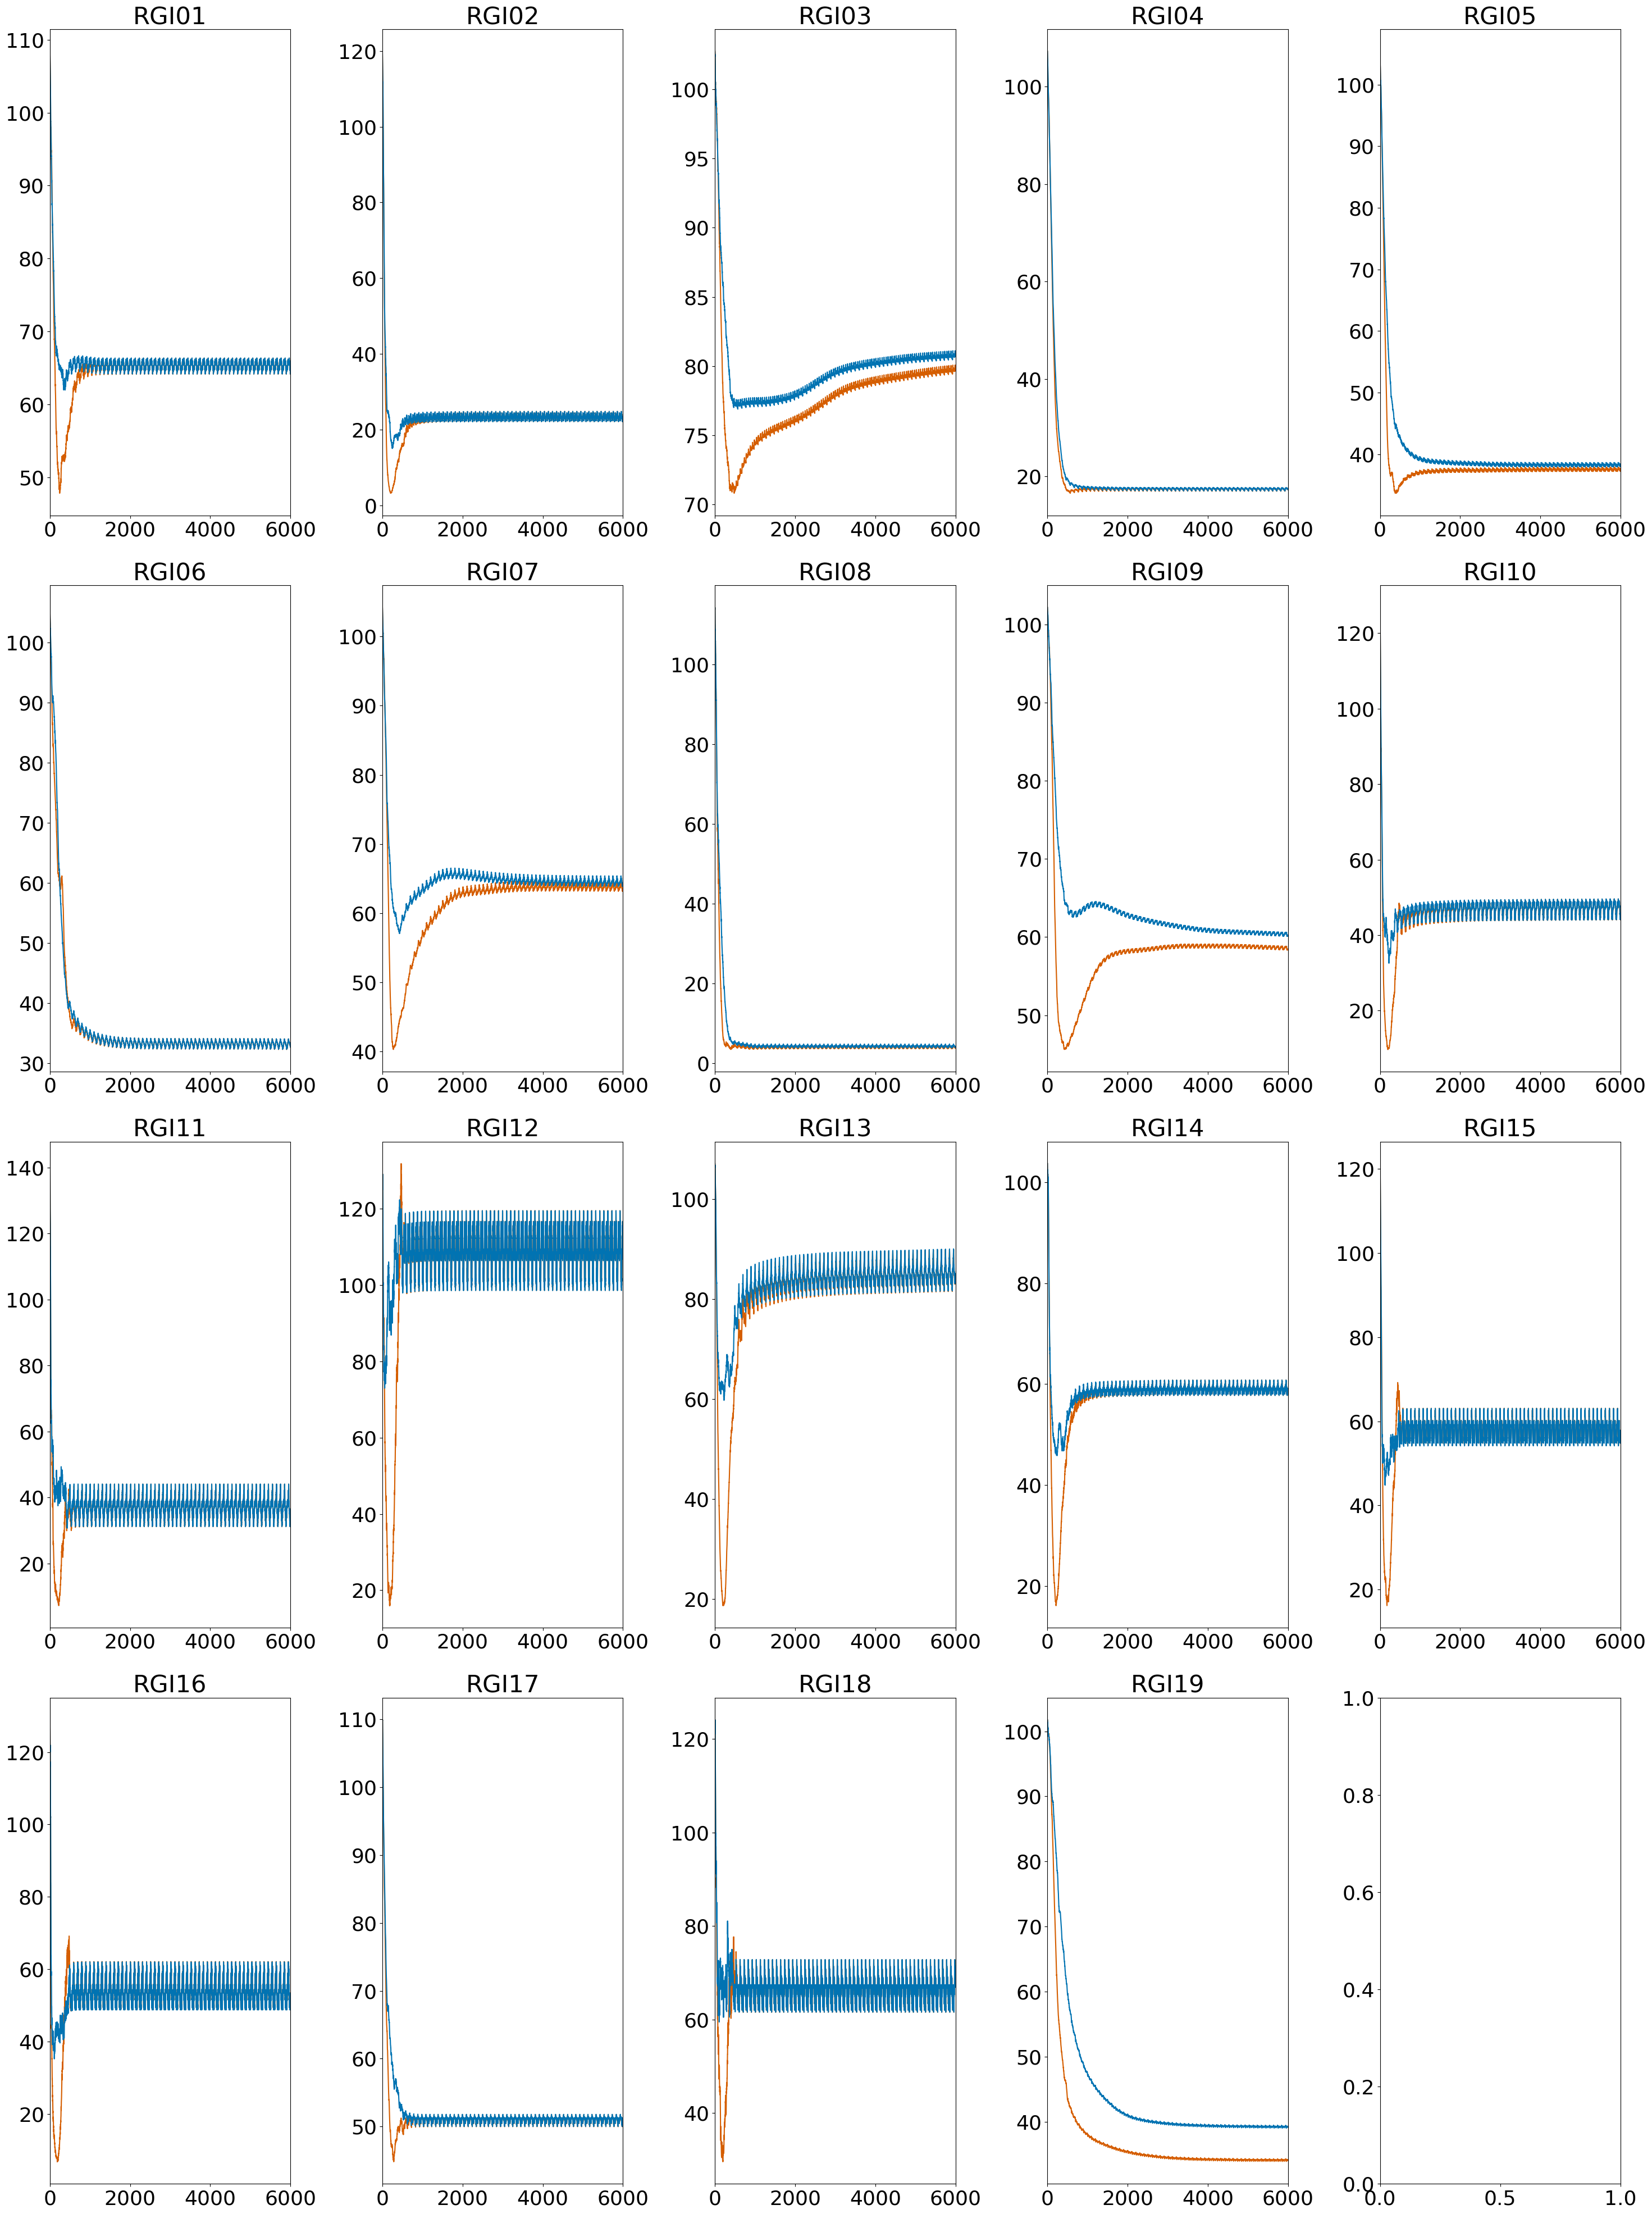

In [41]:
# just a quick check ...
fig, axs = plt.subplots(4,5,figsize=(30,40))
axs = axs.flatten()
for j,rgi_reg in enumerate(df_all.rgi_reg.values):
    ax = axs[j]
    ax.set_title('RGI'+rgi_reg)
    for scenario in df_all.scenario.values:
        df_all_s = df_all.sel(scenario=scenario)
        ax.plot(100*df_all_s.sel(rgi_reg=rgi_reg).squeeze().T/df_all_s.sel(rgi_reg=rgi_reg).sel(time=2020).squeeze(), color=color_scenario[scenario]);
    ax.set_xlim([0,6000])
plt.tight_layout()

## Some characteristics, just for fun!

In [ ]:
df_scenario = _df_scenario.rolling(time=101, center=True, min_periods=101).mean()
df_scenario = df_scenario.dropna(dim='time')

In [30]:
init_vol = (df_scenario_usual.sel(scenario='stab_T15').sel(time=2020).squeeze())
ratio_diff = (df_scenario.sum(dim='rgi_reg').volume - df_scenario.sum(dim='rgi_reg').volume.isel(time=-1))/init_vol.sum(dim='rgi_reg')
condi1 = np.abs(ratio_diff)<0.001

df_scenario_not_stabilised_glob = ratio_diff.where(condi1)
pd_scenario_not_stabilised_glob = df_scenario_not_stabilised_glob.to_dataframe().reset_index()
pd_scenario_not_stabilised_glob['rgi_reg'] = 'Global'
pd_scenario_not_stabilised_glob = pd_scenario_not_stabilised_glob[['scenario', 'rgi_reg', 'time', 'volume']]
pd_scenario_not_stabilised_glob.index = pd_scenario_not_stabilised_glob.time
pd_scenario_not_stabilised_glob = pd_scenario_not_stabilised_glob.dropna()

#condi1 = df_scenario.volume/init_vol>=0.999
#condi2 = df_scenario.volume/init_vol<=1.001
ratio_diff = (df_scenario.volume - df_scenario.volume.isel(time=-1))/init_vol
condi1 = np.abs(ratio_diff)<0.001

df_scenario_not_stabilised = ratio_diff.where(condi1)
pd_scenario_not_stabilised = df_scenario_not_stabilised.to_dataframe().reset_index()
pd_scenario_not_stabilised = pd_scenario_not_stabilised.dropna()

pd_scenario_not_stabilised = pd.concat([pd_scenario_not_stabilised_glob, pd_scenario_not_stabilised])
pd_scenario_not_stabilised = pd_scenario_not_stabilised[['scenario', 'rgi_reg', 'time', 'volume']]
pd_scenario_not_stabilised = pd_scenario_not_stabilised.dropna()

pd_scenario_not_stabilised.index = pd_scenario_not_stabilised.time
pd_scenario_stabilised = pd_scenario_not_stabilised.groupby(['scenario', 'rgi_reg']).idxmin()[['time']].reset_index()
pd_scenario_stabilised = pd_scenario_stabilised.pivot(columns='rgi_reg', index='scenario')
pd_scenario_stabilised.columns = pd_scenario_not_stabilised.rgi_reg.unique()

In [31]:

pd_scenario_stabilised

Global      01      02      03  \
scenario                                                                        
initial state: oversh_T30OS15 after 500 years   700.0  1081.0  9046.0   379.0   
initial state: stab_T15 after 500 years          50.0   855.0  9082.0  1157.0   

                                                   04      05      06     07  \
scenario                                                                       
initial state: oversh_T30OS15 after 500 years  9964.0  1773.0  2683.0  158.0   
initial state: stab_T15 after 500 years         543.0  1797.0   713.0  394.0   

                                                   08      09     10     11  \
scenario                                                                      
initial state: oversh_T30OS15 after 500 years  1545.0  5235.0  255.0   50.0   
initial state: stab_T15 after 500 years        8261.0  4710.0   50.0  570.0   

                                                   12      13     14     15  \
scenario                                                                      
initial state: oversh_T30OS15 after 500 years  6776.0  1957.0   78.0   99.0   
initial state: stab_T15 after 500 years        6629.0  1851.0  120.0  138.0   

                                                  16    17      18      19  
scenario                                                                    
initial state: oversh_T30OS15 after 500 years  279.0  98.0  4108.0  8228.0  
initial state: stab_T15 after 500 years        257.0  50.0  4530.0  1482.0

In [32]:
pd_vol_scenario_rel = (100*df_scenario.volume/(df_scenario_usual.sel(scenario='stab_T15').sel(time=2020).squeeze())).to_dataframe('volume_rel_2020_%').reset_index()
df_scenario_glob = df_scenario.sum(dim='rgi_reg')
pd_vol_scenario_glob = (100*df_scenario_glob.volume/(df_scenario_usual.sum(dim='rgi_reg').sel(scenario='stab_T15').sel(time=2020).values)).to_dataframe('volume_rel_2020_%').reset_index()
pd_vol_scenario_rel['time_true'] = pd_vol_scenario_rel['time'] + 500
pd_vol_scenario_glob['time_true'] = pd_vol_scenario_glob['time'] + 500

pd_vol_scenario_rel_f = pd_vol_scenario_rel.loc[pd_vol_scenario_rel.time==10000.0]
pd_vol_scenario_rel_f.index = pd_vol_scenario_rel_f.rgi_reg
pd_vol_scenario_glob['rgi_reg'] = 'Global'
pd_vol_scenario_glob_f = pd_vol_scenario_glob.loc[pd_vol_scenario_glob.time==10000.0]
pd_vol_scenario_glob_f.index = pd_vol_scenario_glob_f.rgi_reg
pd_vol_scenario_rel_f = pd.concat([pd_vol_scenario_glob_f, pd_vol_scenario_rel_f])
pd_vol_scenario_f_diff = (pd_vol_scenario_rel_f.loc[pd_vol_scenario_rel_f.scenario=='initial state: oversh_T30OS15 after 500 years']['volume_rel_2020_%'] 
                        - pd_vol_scenario_rel_f.loc[pd_vol_scenario_rel_f.scenario=='initial state: stab_T15 after 500 years']['volume_rel_2020_%'])
#pd_vol_scenario_f_diff_zero = pd_vol_scenario_rel_f.loc[pd_vol_scenario_rel_f.scenario=='initial state: zero after 500 years']['volume_rel_2020_%'] - pd_vol_scenario_rel_f.loc[pd_vol_scenario_rel_f.scenario=='initial state: stab_T15 after 500 years']['volume_rel_2020_%']
#pd_stats_stabilisation = pd.DataFrame([pd_vol_scenario_f_diff.round(1), pd_vol_scenario_f_diff_zero.round(1)])
#pd_stats_stabilisation.index = [
#                               'Volume differences between initial states with zero volume and stabilisation +1.5°C scenario (% relative to 2020)']
print('Volume differences between initial states from overshoot +3.0°C->+1.5°C and stabilisation +1.5°C scenario (% relative to 2020)')

pd_vol_scenario_f_diff

Volume differences between initial states from overshoot +3.0°C->+1.5°C and stabilisation +1.5°C scenario (% relative to 2020)


rgi_reg
Global   -1.908302
01       -0.019508
02        0.007357
03       -0.839493
04       -0.039276
05       -0.819813
06       -0.014332
07       -0.728832
08       -0.212461
09       -1.580429
10        0.011230
11       -0.020706
12        0.040787
13       -0.074005
14        0.001110
15        0.033478
16        0.073635
17       -0.034409
18       -0.020142
19       -5.118458
Name: volume_rel_2020_%, dtype: float32

### Year when steady-state is reached:

In [13]:
condi1 = df_scenario.sum(dim='rgi_reg').volume/df_scenario.sum(dim='rgi_reg').volume.isel(time=-1)<=0.99
condi2 = df_scenario.sum(dim='rgi_reg').volume/df_scenario.sum(dim='rgi_reg').volume.isel(time=-1)>=1.01
df_scenario_not_stabilised_glob = df_scenario.sum(dim='rgi_reg').volume.where(condi1|condi2)
pd_scenario_not_stabilised_glob = df_scenario_not_stabilised_glob.to_dataframe().reset_index()
pd_scenario_not_stabilised_glob['rgi_reg'] = 'Global'
pd_scenario_not_stabilised_glob.index = pd_scenario_not_stabilised_glob.time

condi1 = df_scenario.volume/df_scenario.volume.isel(time=-1)<=0.99
condi2 = df_scenario.volume/df_scenario.volume.isel(time=-1)>=1.01
df_scenario_not_stabilised = df_scenario.volume.where(condi1|condi2)
pd_scenario_not_stabilised = df_scenario_not_stabilised.to_dataframe().reset_index()
pd_scenario_not_stabilised.index = pd_scenario_not_stabilised.time
pd_scenario_not_stabilised = pd.concat([pd_scenario_not_stabilised_glob, pd_scenario_not_stabilised])
pd_scenario_not_stabilised.groupby(['scenario', 'rgi_reg'])[['volume']].idxmax()

volume
scenario                                      rgi_reg        
initial state: oversh_T30OS15 after 500 years 01        358.0
                                              02        712.0
                                              03       5818.0
                                              04        273.0
                                              05       9590.0
                                              06         50.0
                                              07       1722.0
                                              08         50.0
                                              09       1118.0
                                              10       1714.0
                                              11        115.0
                                              12          NaN
                                              13       2936.0
                                              14        706.0
                                              15          NaN
                                              16         55.0
                                              17         89.0
                                              18         50.0
                                              19         50.0
                                              Global   2194.0
initial state: stab_T15 after 500 years       01          NaN
                                              02        474.0
                                              03       4922.0
                                              04         50.0
                                              05         50.0
                                              06         50.0
                                              07       1263.0
                                              08         50.0
                                              09        703.0
                                              10       1265.0
                                              11          NaN
                                              12          NaN
                                              13       2625.0
                                              14        501.0
                                              15          NaN
                                              16          NaN
                                              17         50.0
                                              18          NaN
                                              19         50.0
                                              Global     50.0

## TODO- update to RGI regions ... but anyways not shown in manuscript

2252.0 16.058124542236328


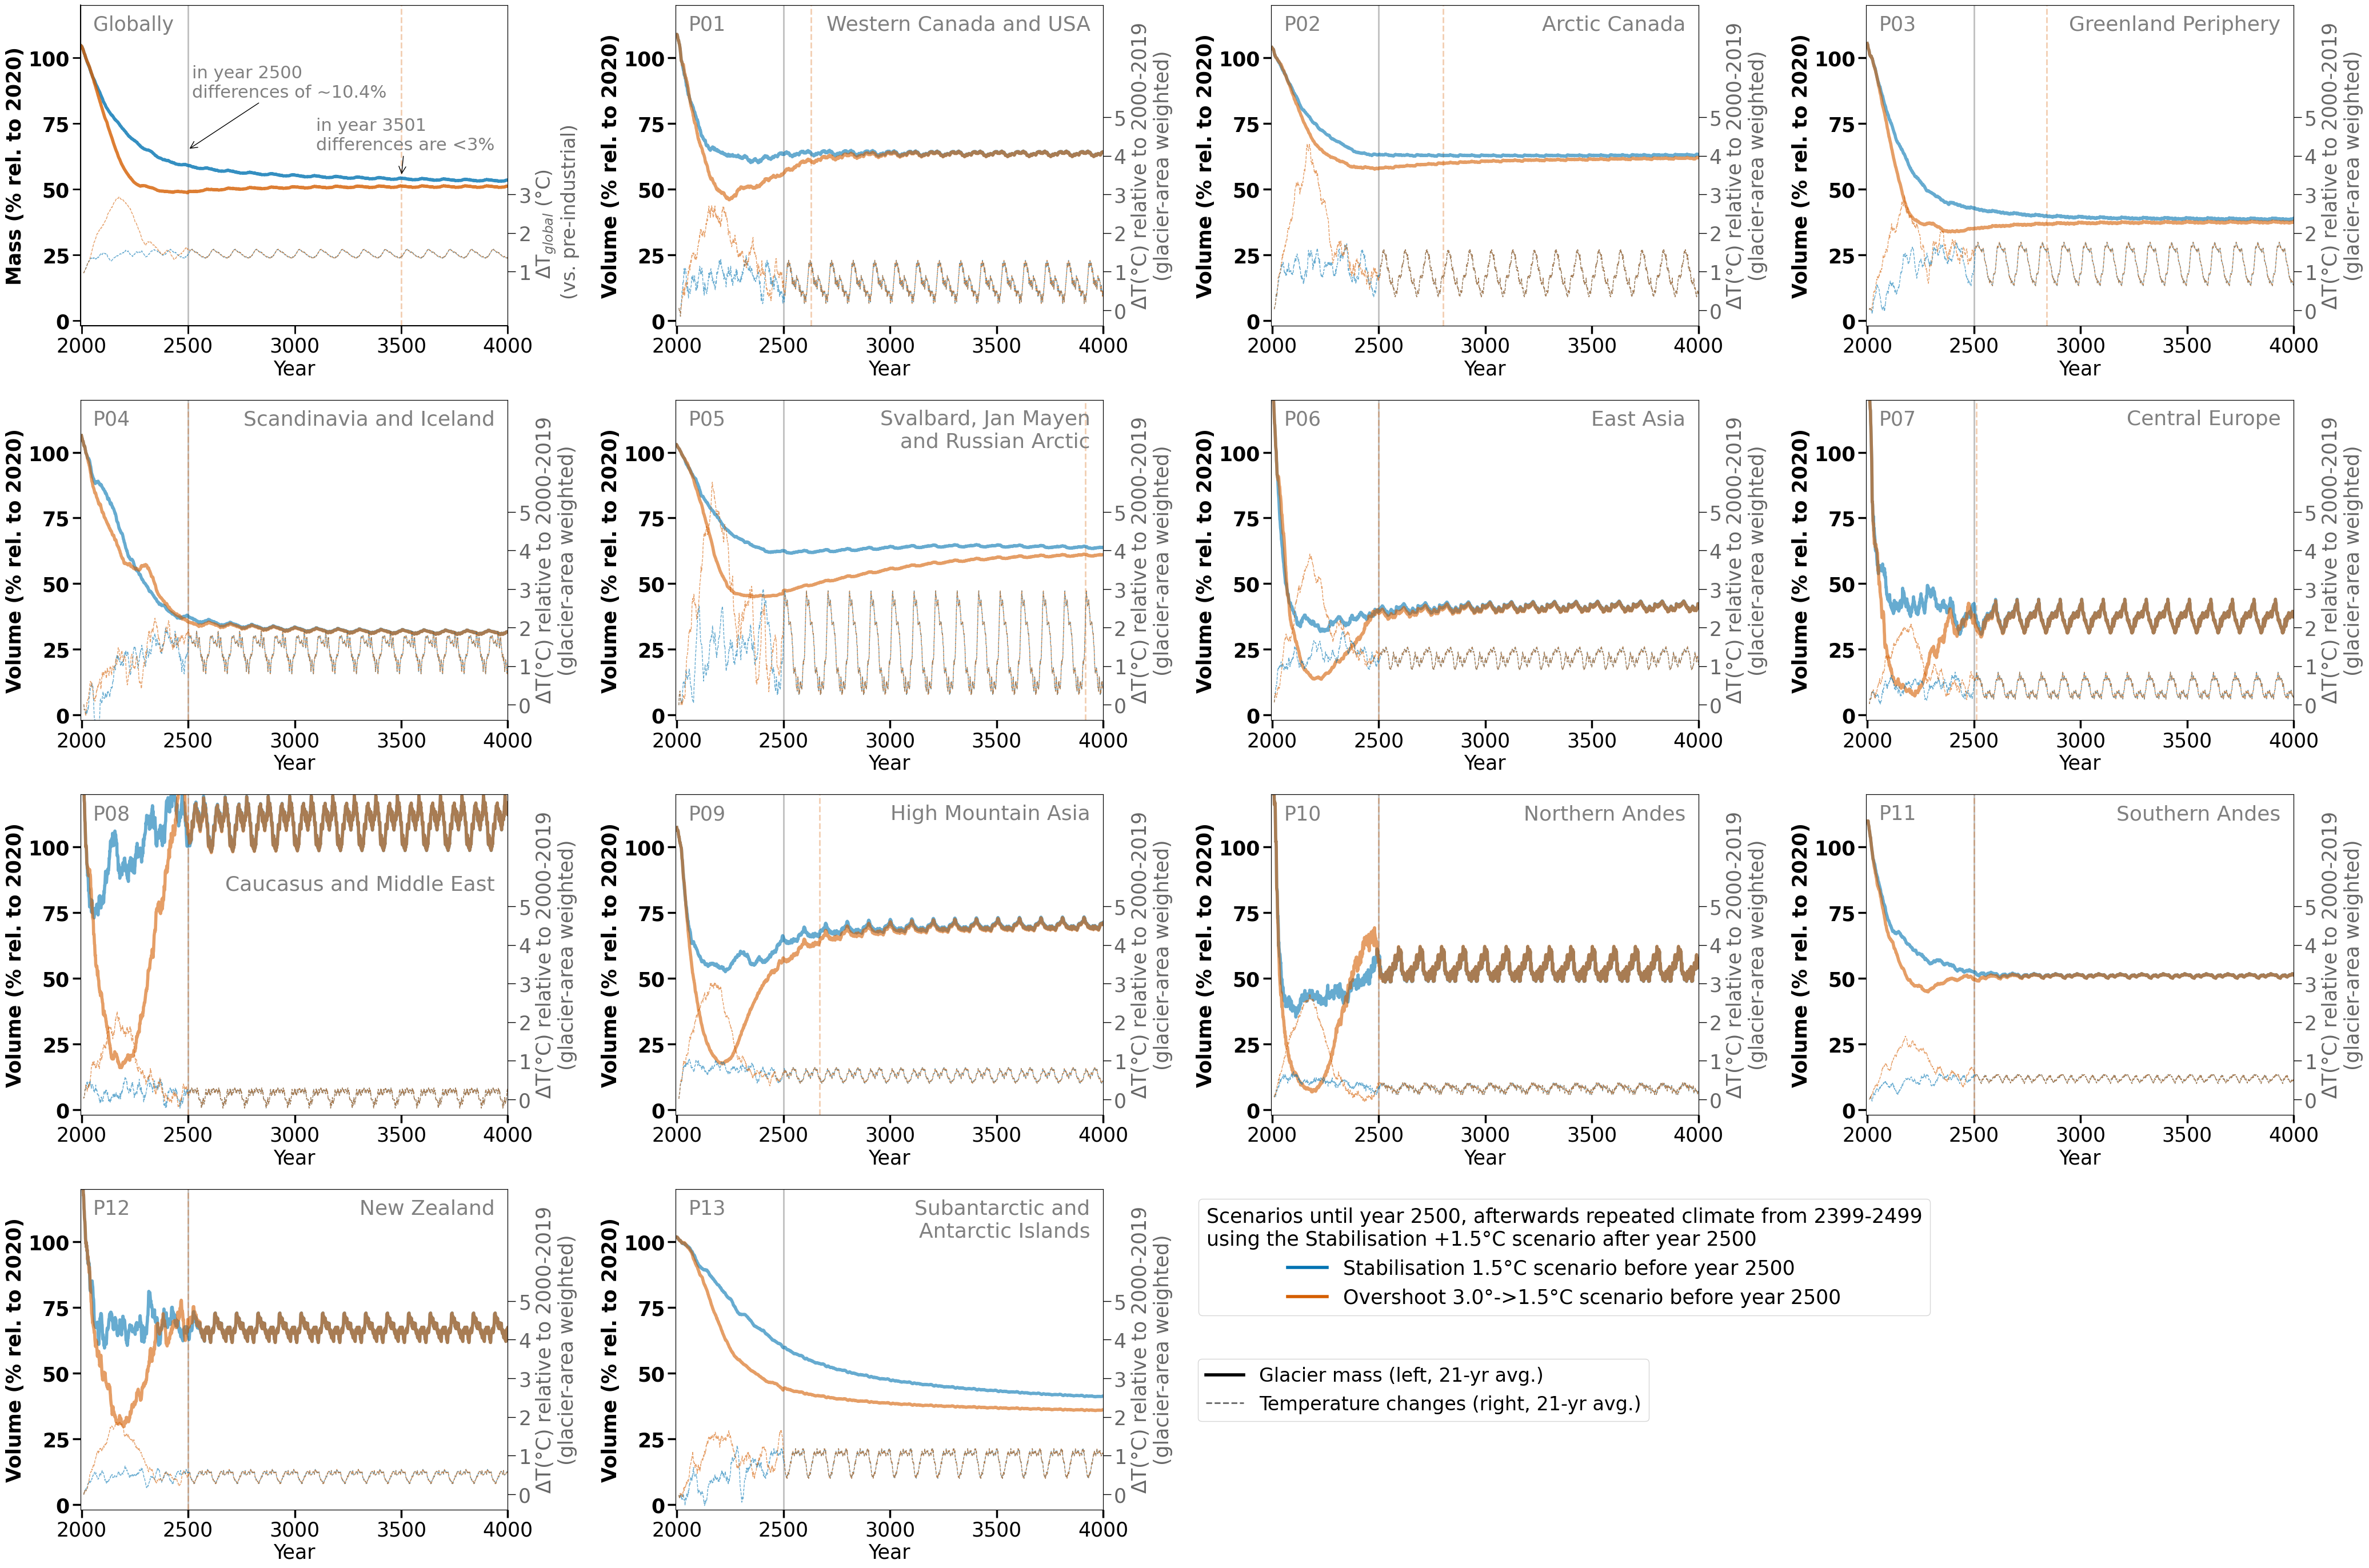

In [23]:
show_temp = True
if not show_temp:
    add = '_no_temp'
else:
    add = ''
    
if show_temp:
    alpha_temp = 1
    alpha_temp2 = 0.6
    width=1
    length=10
else:
    alpha_temp = 0
    alpha_temp2 = 0
    width=0
    length=10
    
show_global_temp = True
if show_global_temp:
    add = '_global_temp'


plt.rc('font', size=25)
portrait = True

plot_vlines = True


for a,color_scenarios in zip(['_all'],
                       [color_scenario_r]):
    #scenarios = color_scenarios.keys()
    scenarios = [ 'stab_T15', 'oversh_T30OS15']
    paletti = list(color_scenarios.values())[:-1]  
    if portrait:
        plt.figure(figsize=(42,28)) #, sharey=True, sharex=True)
        plt.subplot(4,4,1)
    else:
        plt.figure(figsize=(45,16)) #, sharey=True, sharex=True)
        plt.subplot(2,7,1)
    ax = plt.gca()
    #ax.set_title('Globally')
    plt.text(0.03,0.97, 'Globally',
             transform=ax.transAxes,ha='left',va='top',
             color='grey', fontsize=25)
    ax.set_ylabel('Mass (% rel. to 2020)', weight='bold')
    sns.lineplot(data=pd_vol_scenario_rel_glob_all.loc[pd_vol_scenario_rel_glob_all.bias_correction=='bc_1980_2019'],
                 hue='scenario', x='time', y= 'volume_rel_2020_%', 
                 palette=paletti,
                 hue_order=scenarios,lw=4, legend=False, alpha=0.8,
                 ax = ax)
    #ax.set_xlabel('Year')
    #ax.grid(axis='x')
    ax.set_ylim([-2,120]);
    ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')

    for axis in 'left', 'bottom':
        ax.spines[axis].set_linewidth(1.5)

    # set the parameters for both axis: label size in font points, the line tick line 
    # width and length in pixels
    ax.tick_params(axis='both', which='major', width=2, length=10)
    
    ax.set_xlabel('')
    #ax.set_xlim([2000,2500])
    #ax2.set_xlim([2000,2500])
    plt.axvline(2500, color='grey', zorder=-1, lw=2, alpha = 0.5)
    if plot_vlines:
        #for scenario in df_scenario.scenario.values:
        for scenario in ['initial state: oversh_T30OS15 after 500 years']:
            _p_sel = pd_vol_scenario_rel_glob_all#.loc[pd_vol_scenario_rel_glob_all.provide_region == Preg]
            _p_sel.index = _p_sel.time
            _p_sel = _p_sel.loc[_p_sel.scenario == 'stab_T15']['volume_rel_2020_%'] - _p_sel.loc[_p_sel.scenario == 'oversh_T30OS15']['volume_rel_2020_%']
            print(_p_sel.idxmax(), _p_sel.max())
            _p_sel = _p_sel.loc[2499:]
            yr = _p_sel.loc[_p_sel<3].index.min()
            
            plt.axvline(yr,ls='--', alpha = 0.3, lw=2, 
                       color=color_scenario_r[scenario], zorder=-1)
            if 'oversh' in scenario:
                plt.annotate(xy=(yr, 55),
                             xytext=(yr-400,65), text=f'in year {int(yr)}\ndifferences are <3%',
                             color='grey',arrowprops={'arrowstyle':'->'}, fontsize=22)
                _diff = _p_sel.loc[2499].round(1) # use 2499
                plt.annotate(xy=(2500, 65),
                             xytext=(2500+20,85), text=f'in year 2500\ndifferences of ~{_diff:0.1f}%',
                             color='grey',arrowprops={'arrowstyle':'->'}, fontsize=22)
    ax.set_xlabel('Year')

    ax2 = ax.twinx()  
    for scenario in scenarios:
        
        if show_global_temp:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            _p_sel2 = pd_clim_all.loc[pd_clim_all.region=='global']
            _p_sel2 = _p_sel2.loc[_p_sel2.scenario == 'stab_T15']
            _p_sel2.index = _p_sel2.year
            _p_sel = _p_sel2.loc[2399:2500]['temp']
            _temp_vals = np.tile(_p_sel.values, 50)
            pd_temp_vals = pd.DataFrame(index=np.arange(2000,len(_temp_vals)+2500,1))
            pd_temp_vals.loc[2500:, 'temp'] = _temp_vals
            pd_temp_vals.loc[2000:2499, 'temp'] = pd_clim_scenario_g.loc[2000:2499]['temp'].values
            pd_temp_vals = pd_temp_vals.rolling(21, center=True, min_periods=21).mean()
            var_g_to_ref = pd_temp_vals['temp']- pd_clim_scenario_g_ref + 0.63

            ax2.plot(pd_temp_vals.index,#pd_clim_scenario_g.year,
                var_g_to_ref, alpha = alpha_temp2, 
                ls = '--',
                 lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
        else:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == 'global_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            _p_sel2 = pd_clim_all.loc[pd_clim_all.region=='global_glacier']
            _p_sel2 = _p_sel2.loc[_p_sel2.scenario == 'stab_T15']
            _p_sel2.index = _p_sel2.year
            _p_sel = _p_sel2.loc[2399:2500]['temp']
            _temp_vals = np.tile(_p_sel.values, 50)
            pd_temp_vals = pd.DataFrame(index=np.arange(2000,len(_temp_vals)+2500,1))
            pd_temp_vals.loc[2500:, 'temp'] = _temp_vals
            pd_temp_vals.loc[2000:2499, 'temp'] = pd_clim_scenario_g.loc[2000:2499]['temp'].values
            pd_temp_vals = pd_temp_vals.rolling(21, center=True, min_periods=21).mean()

            var_g_to_ref =pd_temp_vals['temp'] - temp_ref_g
            ax2.plot(pd_temp_vals.index,
                     var_g_to_ref,
                     alpha = alpha_temp2, 
                     ls = '--',
                     lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
    if show_global_temp:
        ax2.set_yticks(ticks=[1,2,3],
                       labels=[1,2,3], alpha=alpha_temp2)
        ax2.set_ylim([-0.4,7.9]);
    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                       labels=[0,1,2,3,4,5], alpha=alpha_temp2)
        ax2.set_ylim([-0.4,7.9]);

    #plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
    #ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=width, length=length, grid_alpha =alpha_temp2)
    handles_2, labels_2_nice = ax2.get_legend_handles_labels()
    
    if show_global_temp:
        ax2.set_ylabel(r'$\Delta$T$_{global}$ (°C)                    '+'\n(vs. pre-industrial)               ',
                                      alpha = alpha_temp2, fontsize=24)
    else:
        ax2.set_ylabel(r'$\Delta$T'+'(°C) relative to 2000-2019\n(glacier-area weighted)',
                                  alpha = alpha_temp2, fontsize=24)
    ax.set_xlim([1995,4000])
    ax2.set_xlim([1995,4000])

    
    for j, pi in enumerate(np.arange(1,14,1)):
        if pi<10:
            Preg = f'P0{pi}'
        else:
            Preg = f'P{pi}'
            
            
            
        if portrait:
            plt.subplot(4,4,j+2)
            x_j = np.arange(0,16,1)
            x2_j = x_j
            #x_j = np.arange(3,15,4)
            #x2_j = np.arange(2,15,4)
            year_xlabel_condi = j>10

        else:
            plt.subplot(2,7,j+2)
            x_j = [6]
            x2_j = [5,12]
            year_xlabel_condi = j>5
        ax = plt.gca()
        pd_vol_scenario_rel_reg = pd_vol_scenario_rel_all.loc[pd_vol_scenario_rel_all.provide_region==Preg]
        if pi ==13:
            legend=True
        else:
            legend=False
        sns.lineplot(data=pd_vol_scenario_rel_reg.loc[pd_vol_scenario_rel_reg.bias_correction=='bc_1980_2019'],
                     hue='scenario', x='time', y= 'volume_rel_2020_%', 
                     palette=paletti,
                 hue_order=scenarios,lw=4, legend=legend, alpha =0.6, 
                 ax = ax)

        #ax.set_title(f'{Preg}')
        plt.text(0.03,0.97, Preg,
                 transform=ax.transAxes,ha='left',va='top',
                 color='grey', fontsize=25)
        if Preg == 'P08':
            yy = 0.75
        else:
            yy= 0.97
        plt.text(0.97,yy, provide_reg_full_name_dict[Preg],
                 transform=ax.transAxes,ha='right',va='top',
                 color='grey', fontsize=26)
        ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')
        if j in x_j:
            ax.set_ylabel('Volume (% rel. to 2020)', weight='bold')
            ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')
        else:
            plt.ylabel('')
            ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], alpha=0, fontsize=1) #visible=False) 
            #plt.setp(ax.get_yticklabels(), visible=False)

        ax.set_ylim([-2,120]);
        ax.tick_params(axis='both', which='major', width=2.5, length=10)
        
        if year_xlabel_condi:
            ax.set_xlabel('Simulation years (after year 2500)')
        else:
            ax.set_xlabel('')

        #ax.set_xlim([2000,2500])
        #ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
        #ax2.set_xlim([2000,2500])
        #ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)  
        plt.axvline(2500, color='grey', zorder=-1, lw=2, alpha = 0.5)

        if plot_vlines:
            _p_sel = pd_vol_scenario_rel_all.loc[pd_vol_scenario_rel_all.provide_region == Preg]
            _p_sel.index = _p_sel.time
            _p_sel = _p_sel.loc[_p_sel.scenario == 'stab_T15']['volume_rel_2020_%'] - _p_sel.loc[_p_sel.scenario == 'oversh_T30OS15']['volume_rel_2020_%']
            _p_sel = _p_sel.loc[2500:]
            _p_sel.loc[_p_sel<3].index.min()
            yr = _p_sel.loc[_p_sel<3].index.min()
            for scenario in ['initial state: oversh_T30OS15 after 500 years']: #df_scenario.scenario.values:
                plt.axvline(yr,ls='--', alpha = 0.3, lw=2, 
                            zorder=-1,
                       color=color_scenario_r[scenario])
        
        
        if pi ==13:
            han, lab = ax.get_legend_handles_labels()
            lab[0] = 'Stabilisation 1.5°C scenario before year 2500'
            lab[1] = 'Overshoot 3.0°->1.5°C scenario before year 2500'
            #lab[2] = 'initial state with zero volume'
            ax.legend().remove()
        ax.set_xlim([1995,4000])
        
        ax2 = ax.twinx()              
            
        for scenario in scenarios:
            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'provide_reg_{Preg}_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

            _p_sel2 = pd_clim_all.loc[pd_clim_all.region==f'provide_reg_{Preg}_glacier']
            _p_sel2 = _p_sel2.loc[_p_sel2.scenario == 'stab_T15']
            _p_sel2.index = _p_sel2.year
            _p_sel = _p_sel2.loc[2399:2500]['temp']
            _temp_vals = np.tile(_p_sel.values, 50)
            pd_temp_vals = pd.DataFrame(index=np.arange(2000,len(_temp_vals)+2500,1))
            pd_temp_vals.loc[2500:, 'temp'] = _temp_vals
            pd_temp_vals.loc[2000:2499, 'temp'] = pd_clim_scenario_g.loc[2000:2499]['temp'].values
            pd_temp_vals = pd_temp_vals.rolling(21, center=True, min_periods=21).mean()

            var_g_to_ref =pd_temp_vals['temp'] - temp_ref_g
            ax2.plot(pd_temp_vals.index,
                     var_g_to_ref,
                     alpha = alpha_temp2, 
                     ls = '--',
                     lw=1, color = color_scenario[scenario], label=label_scenario[scenario])

        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=alpha_temp2)
        if j in x2_j:
            ax2.set_ylabel(r'$\Delta$T'+'(°C) relative to 2000-2019\n(glacier-area weighted)',
                          alpha = alpha_temp2)
            #ax2.set_yticks(labels=[0,1,2,3,4], alpha=0.6)
        else:
            ax2.set_ylabel('')
            #ax2.set_yticks([])
            plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
        
        ax2.set_ylim([-0.4,7.9]);

        ax2.tick_params(axis='both', which='major', width=width, length=length, grid_alpha =alpha_temp2)  
        handles_2, labels_2 = ax2.get_legend_handles_labels()
        ax2.set_xlim([1995,4000])
        ax.set_xlabel('Year')

    plt.tight_layout()
    leg = ax.legend(han, lab, loc = 'upper left',
                    bbox_to_anchor=(1.2,1),
                    title='Scenarios until year 2500, afterwards repeated climate from 2399-2499\nusing the Stabilisation +1.5°C scenario after year 2500')
    for l in leg.get_lines():
        l.set_linewidth(4)
        
        
    if show_temp:
        leg2 = ax.legend([han[0], handles_2[0]], ['Glacier mass (left, 21-yr avg.)',
                                                      'Temperature changes (right, 21-yr avg.)'],
                         loc='upper left', ncol=1, fontsize=24,
                        bbox_to_anchor=(1.2,0.5),)
        leg2.get_lines()[0].set_linewidth(4)
        leg2.get_lines()[1].set_linewidth(2)
        for l in leg2.get_lines():
            l.set_color('black')
        ax.add_artist(leg)
    #if portrait:
    #    plt.savefig(f'4_provide_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation.pdf')
    plt.savefig(f'figures/4_provide_reg_reversibility_V2_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation{add}.png', dpi=300)

    #else:
    #    plt.savefig(f'4_provide_reg_volume_changes_overshoot{a}_{bc}_random_climate_stabilisation.pdf')


*Same stats with the common running glaciers (that also run for 4000 years...)*

In [3]:
df_scenario_random_ss = xr.open_dataset(f'../data/common_running_random_climate_stab_T15_sum_all_rgi_reg_oversh_stab_bc_1980_2019.nc').volume#
# this is for the year 2500
100*df_scenario_random_ss.sel(rgi_reg='19').isel(time=-1)/df_scenario_random_ss.sel(rgi_reg='19').sel(time=2020)

<xarray.DataArray 'volume' (bias_correction: 1, scenario: 2, gcm: 1)>
array([[[97.857216],
        [97.738495]]], dtype=float32)
Coordinates:
    hydro_month      int64 10
    calendar_month   int64 1
  * gcm              (gcm) object 'GFDL-ESM2M'
  * scenario         (scenario) object 'initial state: oversh_T30OS15 after 5...
  * bias_correction  (bias_correction) object 'bc_1980_2019'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'
    rgi_reg          <U2 '19'

In [4]:
df_scenario_random_ss.sum(dim='rgi_reg').isel(time=0)

<xarray.DataArray 'volume' (bias_correction: 1, scenario: 2, gcm: 1)>
array([[[6.8722102e+13],
        [8.3369224e+13]]], dtype=float32)
Coordinates:
    time             float64 0.0
    hydro_year       int64 ...
    calendar_year    int64 ...
    calendar_month   int64 ...
  * gcm              (gcm) object 'GFDL-ESM2M'
  * scenario         (scenario) object 'initial state: oversh_T30OS15 after 5...
  * bias_correction  (bias_correction) object 'bc_1980_2019'
    OGGM_version     object ...

<xarray.DataArray 'volume' ()>
array(1.499621e+14, dtype=float32)
Coordinates:
    time            float64 2.02e+03
    hydro_year      int64 2020
    calendar_year   int64 2020
    calendar_month  int64 1
    OGGM_version    <U22 'OGGM_v161_gdirs_2023.3'

In [44]:
#df_scenario_random_ss = xr.open_dataset(f'common_running_of_random_runs_sum_all_provide_reg_oversh_stab_2000_2500_bc_1980_2019.nc').volume#
# this is for the year 2499
vol_2020_glob = df_scenario.sum(dim='rgi_reg').sel(time=2020).volume.mean()
100*df_scenario_random_ss.sum(dim='rgi_reg').isel(time=0)/vol_2020_glob

<xarray.DataArray 'volume' (bias_correction: 1, scenario: 3, gcm: 1)>
array([[[46.18514 ],
        [55.598003],
        [ 0.      ]]], dtype=float32)
Coordinates:
    calendar_month   int64 1
  * gcm              (gcm) object 'GFDL-ESM2M'
  * scenario         (scenario) object 'initial state: oversh_T30OS15 after 5...
  * bias_correction  (bias_correction) object 'bc_1980_2019'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'

In [45]:
55.598003- 46.185

9.413002999999996

-- todo end---

### Analysis for single glaciers - not used in manuscript

In [29]:
rgi_meta = pd.read_hdf('/home/www/oggm/rgi/rgi62_stats.h5')
rgi_meta = rgi_meta.loc[rgi_meta.Connect != 2]

In [33]:
rgi_reg = '19'

In [34]:
fpath = '/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output/rgi_reg'
ds_oversh_500yr = xr.open_dataset(f'{fpath}/{rgi_reg}/rgi_reg_{rgi_reg}_oversh_T30OS15_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_bc_1980_2019.nc')[['volume']]
ds_oversh_random = xr.open_dataset(f'{fpath}/{rgi_reg}/random_climate_from2500_using2399_2499_rgi_reg_{rgi_reg}_initial_oversh_T30OS15_w5e5_gcm_merged_from_2000_bc_1980_2019.nc')
ds_oversh_random['time'] = ds_oversh_random.time.values + 2500
ds_T15_500yr = xr.open_dataset(f'{fpath}/{rgi_reg}/rgi_reg_{rgi_reg}_stab_T15_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_bc_1980_2019.nc')
ds_T15_random = xr.open_dataset(f'{fpath}/{rgi_reg}/random_climate_from2500_using2399_2499_rgi_reg_{rgi_reg}_initial_stab_T15_w5e5_gcm_merged_from_2000_bc_1980_2019.nc')[['volume']]
ds_T15_random['time'] = ds_T15_random.time.values + 2500

ds_zero = xr.open_dataset(f'{fpath}/{rgi_reg}/random_climate_from2500_using2399_2499_rgi_reg_{rgi_reg}_initial_zero_w5e5_gcm_merged_from_2000_bc_1980_2019.nc')
ds_zero['time'] = ds_zero.time.values + 2500

#ds_zero['time'] = ds_zero.time.values + 2500
ds_oversh_roll = ds_oversh_random.rolling(time=21, center=True).mean()
ds_T15_roll = ds_T15_random.rolling(time=21, center=True).mean()
ds_roll = ds_zero.rolling(time=21, center=True).mean()

# ds_oversh = xr.concat([ds_oversh_500yr, ds_oversh_random], dim = 'time')
ds_oversh_500yr_roll = ds_oversh_500yr.rolling(time=21, center=True).mean()
ds_T15_500yr_roll = ds_T15_500yr.rolling(time=21, center=True).mean()


In [ ]:
ds_oversh_random.volume.sel(time=2500)

In [35]:
fraction = ds_roll.volume.dropna(dim='time', how='all')/ds_T15_roll.volume.dropna(dim='time', how='all').values
fraction_f = fraction.sel(time=10051+2500-50)

fraction_oversh = ds_oversh_roll.volume.dropna(dim='time', how='all')/ds_T15_roll.volume.dropna(dim='time', how='all').values
fraction_oversh_f = fraction_oversh.sel(time=10051+2500-50)

In [36]:
#above 1km3 and a fraction of at least 0.9
fraction_oversh_f_sel = fraction_oversh_f.where((fraction_oversh_f<=0.9) & (ds_oversh_roll.volume.sel(time=10051+2500-50)>5e10)).dropna(dim='rgi_id')
rgis_strange = fraction_oversh_f_sel.rgi_id.values
rgi_meta_strange = rgi_meta.loc[rgis_strange]
rgi_meta_strange['Glacier_Type_Terminus'] = rgi_meta_strange.GlacierType +'_'+rgi_meta_strange.TerminusType
rgi_meta_strange
#rgi_meta_strange.groupby('Glacier_Type_Terminus').count()

GLIMSId   BgnDate   EndDate   CenLon   CenLat O1Region  \
RGIId                                                                           
RGI60-19.00119  G289014E69843S  20010219  -9999999 -70.9856 -69.8427       19   
RGI60-19.00893  G303675E63072S  19900218  -9999999 -56.3246 -63.0715       19   

               O2Region      Area  Zmin  Zmax  ...  TermType  Surging  \
RGIId                                          ...                      
RGI60-19.00119       19  2251.230    10  2530  ...         5        9   
RGI60-19.00893       21   432.818    10   390  ...         1        9   

                Linkages  Name  GlacierType        TerminusType  \
RGIId                                                             
RGI60-19.00119         9  None      Glacier   Shelf-terminating   
RGI60-19.00893         9  None      Glacier  Marine-terminating   

                     GlacierStatus  IsTidewater  IsNominal  \
RGIId                                                        
RGI60-19.00119  Glacier or ice cap        False      False   
RGI60-19.00893  Glacier or ice cap         True      False   

                     Glacier_Type_Terminus  
RGIId                                       
RGI60-19.00119   Glacier_Shelf-terminating  
RGI60-19.00893  Glacier_Marine-terminating  

[2 rows x 27 columns]

In [38]:
# the glacier with the largest differences 
fraction_oversh_f_sel_extreme = fraction_oversh_f.where((fraction_oversh_f<=0.6) & (ds_oversh_roll.volume.sel(time=10051+2500-50)>1e11)).dropna(dim='rgi_id') # at least 1km3 big in the new steady-state
fraction_oversh_f_sel_extreme.rgi_id

<xarray.DataArray 'rgi_id' (rgi_id: 1)>
array(['RGI60-19.00119'], dtype=object)
Coordinates:
    time             float64 1.25e+04
  * rgi_id           (rgi_id) object 'RGI60-19.00119'
    hydro_year       int64 10001
    hydro_month      int64 10
    calendar_year    int64 10001
    calendar_month   int64 1
    bias_correction  <U12 'bc_1980_2019'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'
Attributes:
    description:  RGI glacier identifier

In [40]:
fraction_f_sel = fraction_f.where((fraction_f<=0.9) & (ds_roll.volume.sel(time=10051-50)>5e10)).dropna(dim='rgi_id') # at least 1km3 big in the new steady-state
rgi_meta.loc[fraction_f_sel.rgi_id]

GLIMSId   BgnDate   EndDate    CenLon   CenLat  \
RGIId                                                                   
RGI60-19.00113  G289727E69498S  19890220  20010219  -70.2728 -69.4976   
RGI60-19.00115  G289924E70013S  19790299  -9999999  -70.0759 -70.0127   
RGI60-19.00118  G289474E70612S  19790299  -9999999  -70.5258 -70.6118   
RGI60-19.00119  G289014E69843S  20010219  -9999999  -70.9856 -69.8427   
RGI60-19.00167  G290544E70875S  19790299  -9999999  -69.4564 -70.8754   
RGI60-19.00417  G233765E73569S  -9999999  -9999999 -126.2350 -73.5690   
RGI60-19.00423  G260838E72287S  19721204  19730130  -99.1619 -72.2868   
RGI60-19.00573  G304182E63271S  19900218  20000129  -55.8182 -63.2711   
RGI60-19.01249  G287448E69562S  20010219  20020126  -72.5525 -69.5617   

               O1Region O2Region      Area  Zmin  Zmax  ...  Form  TermType  \
RGIId                                                   ...                   
RGI60-19.00113       19       19  1330.643    10  2810  ...     0         1   
RGI60-19.00115       19       19  2140.685    10  3070  ...     0         5   
RGI60-19.00118       19       19  1966.464    10  2490  ...     0         5   
RGI60-19.00119       19       19  2251.230    10  2530  ...     0         5   
RGI60-19.00167       19       19   389.774    10  1150  ...     0         5   
RGI60-19.00417       19       16  2938.121    10  3010  ...     0         1   
RGI60-19.00423       19       18  5260.723    10   770  ...     0         5   
RGI60-19.00573       19       21  1472.829    10   810  ...     0         1   
RGI60-19.01249       19       19   688.885    10   530  ...     0         1   

                Surging  Linkages                  Name  GlacierType  \
RGIId                                                                  
RGI60-19.00113        9         9                  None      Glacier   
RGI60-19.00115        9         9      Alexander Island      Glacier   
RGI60-19.00118        9         9      Alexander Island      Glacier   
RGI60-19.00119        9         9                  None      Glacier   
RGI60-19.00167        9         9      Alexander Island      Glacier   
RGI60-19.00417        9         9     W Siple Island IC      Glacier   
RGI60-19.00423        9         9        Thurston I 001      Glacier   
RGI60-19.00573        9         9                  None      Glacier   
RGI60-19.01249        9         9  Rothschild Island IC      Glacier   

                      TerminusType       GlacierStatus  IsTidewater  IsNominal  
RGIId                                                                           
RGI60-19.00113  Marine-terminating  Glacier or ice cap         True      False  
RGI60-19.00115   Shelf-terminating  Glacier or ice cap        False      False  
RGI60-19.00118   Shelf-terminating  Glacier or ice cap        False      False  
RGI60-19.00119   Shelf-terminating  Glacier or ice cap        False      False  
RGI60-19.00167   Shelf-terminating  Glacier or ice cap        False      False  
RGI60-19.00417  Marine-terminating  Glacier or ice cap         True      False  
RGI60-19.00423   Shelf-terminating  Glacier or ice cap        False      False  
RGI60-19.00573  Marine-terminating  Glacier or ice cap         True      False  
RGI60-19.01249  Marine-terminating  Glacier or ice cap         True      False  

[9 rows x 26 columns]

In [41]:
rgis_select = list(set(np.concatenate([fraction_oversh_f_sel.rgi_id.values.flatten(),fraction_f_sel.rgi_id.values.flatten()])))

In [52]:
# check if the starting volume from the random overshoot is really the same as the ending volume from the 500 year run!!!
np.testing.assert_allclose(ds_oversh_random.volume.sel(time=2500).sel(rgi_id=rgis_select), ds_oversh_500yr.volume.sel(time=2500).sel(rgi_id=rgis_select))

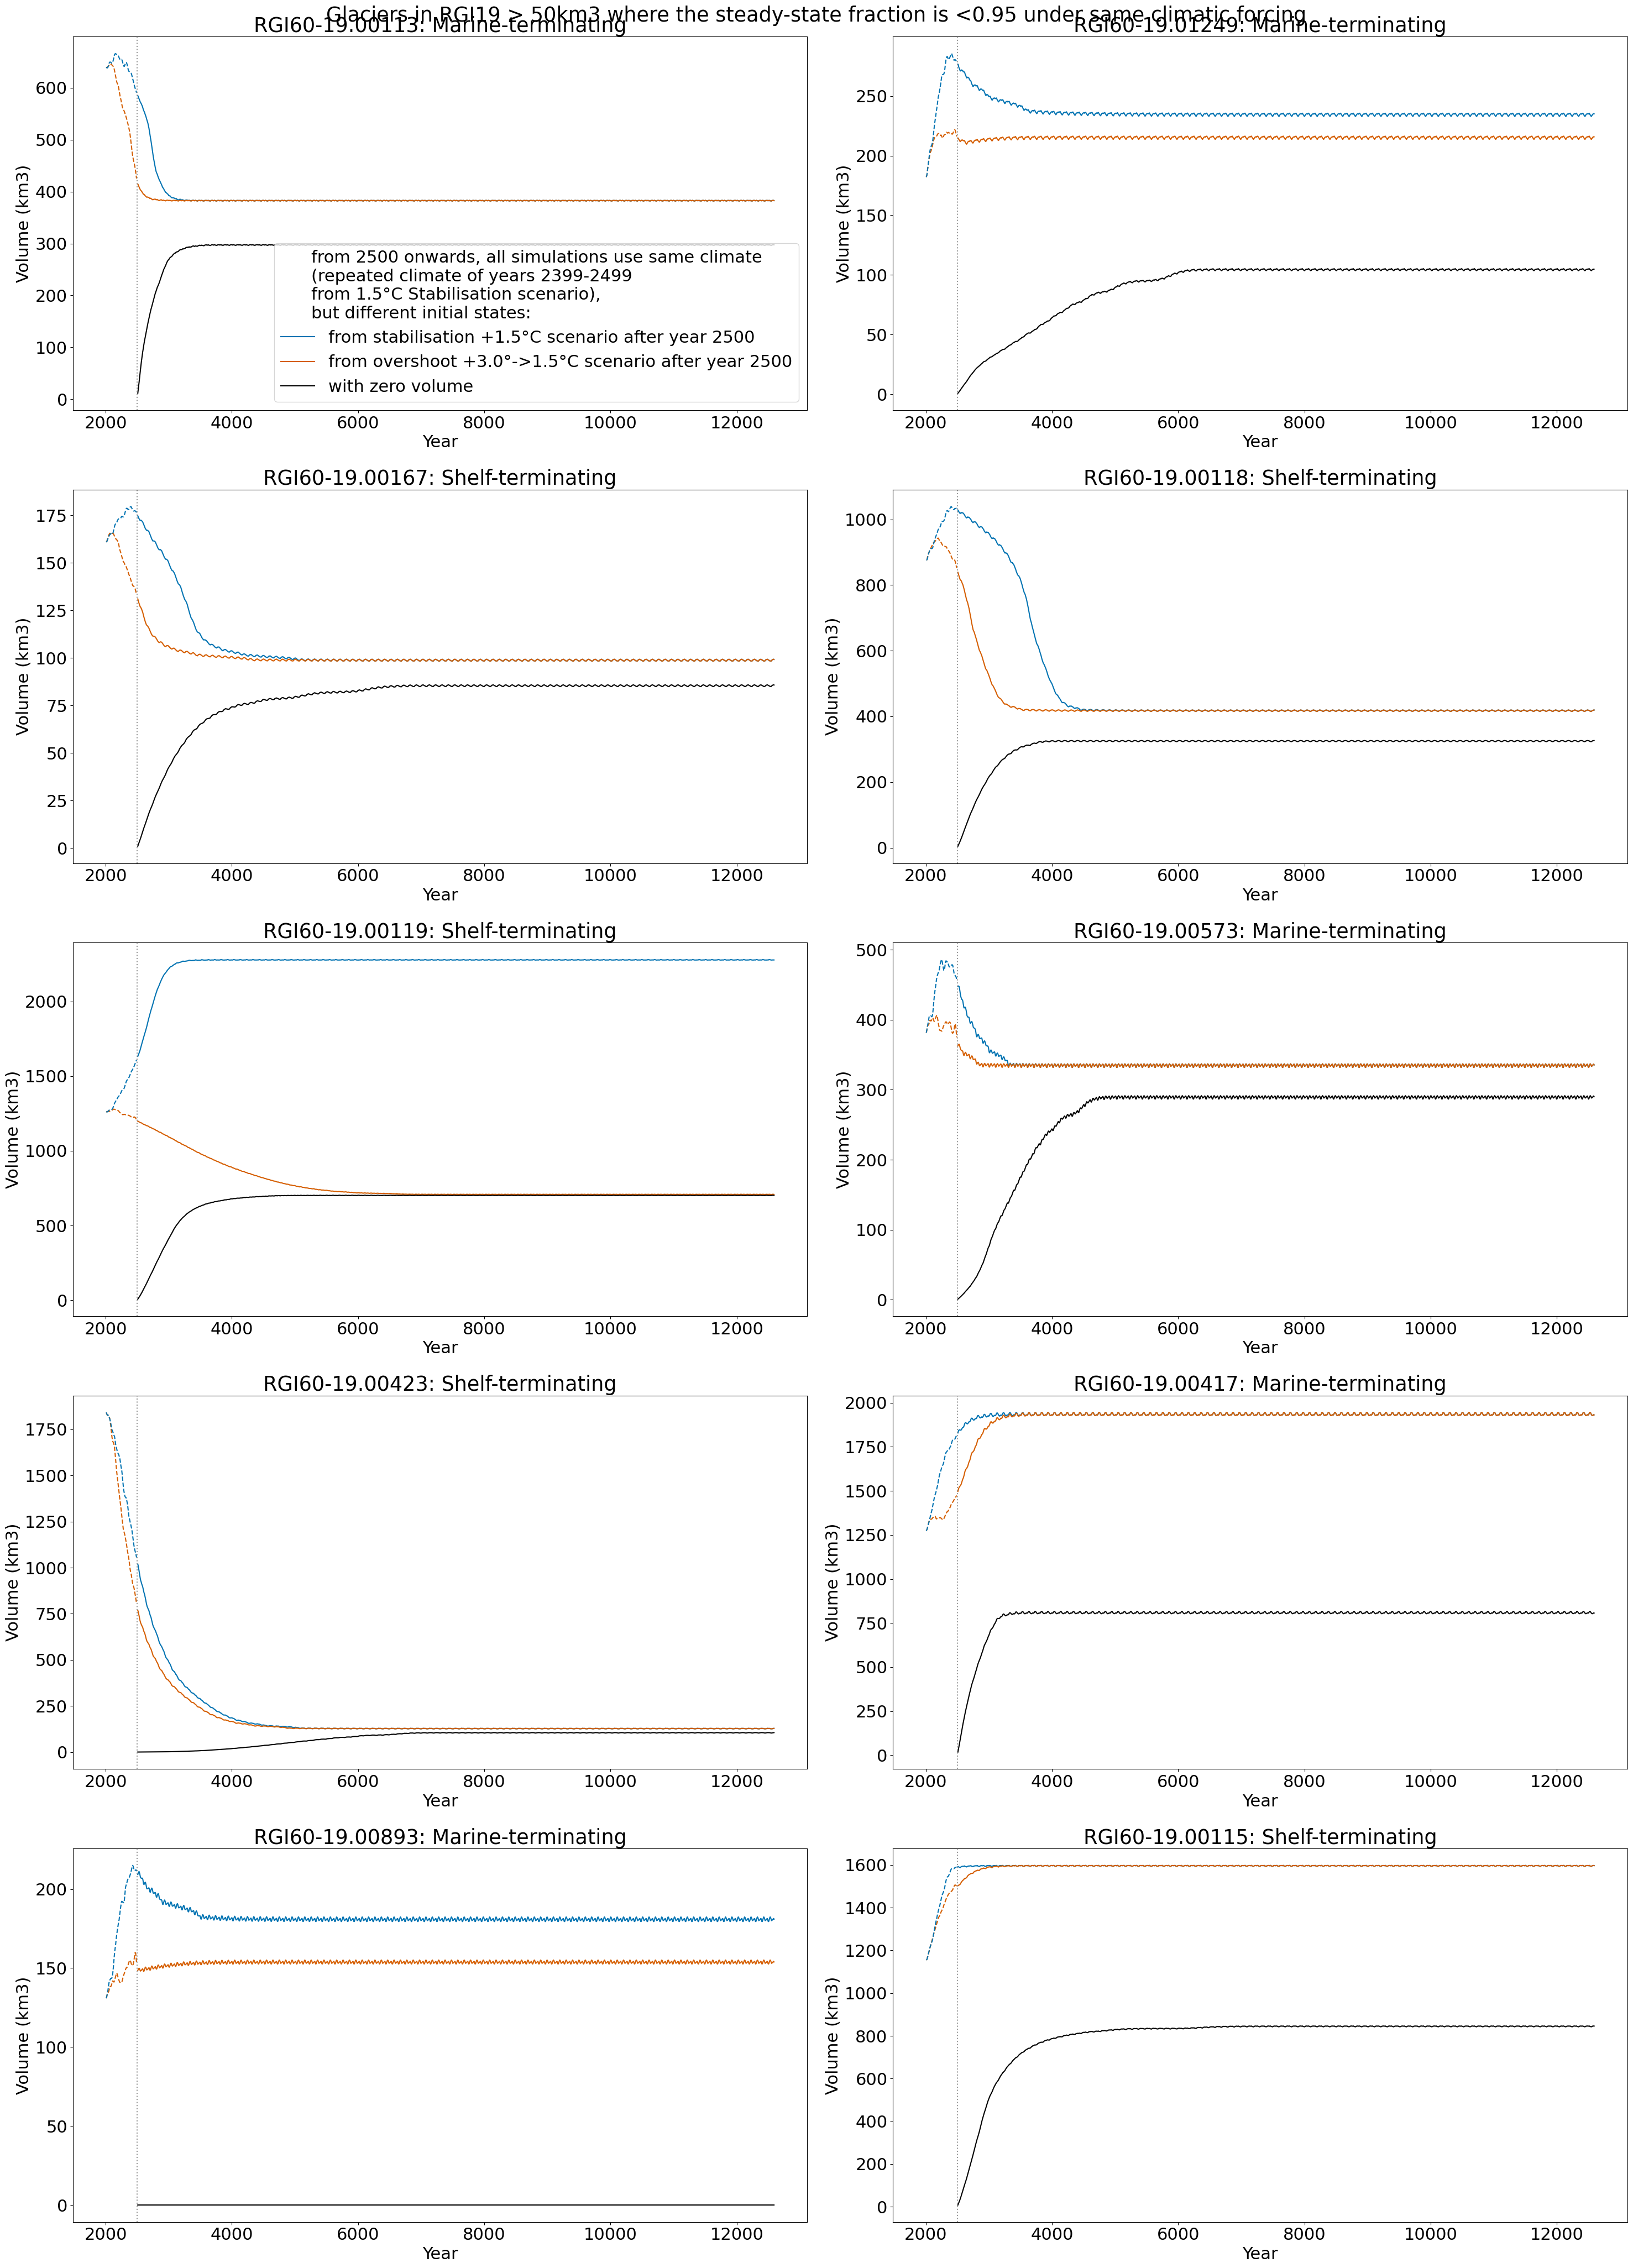

In [55]:
plt.rc('font', size=22)

fig,axs = plt.subplots(5,2,figsize=(30,42)) #, sharey=True)
axs =axs.flatten()
for j,rgi in enumerate(rgis_select):
    ax = axs[j]
    ax.plot(ds_oversh_500yr_roll.time, ds_oversh_500yr_roll.sel(rgi_id=rgi).volume.squeeze()/1e9, color=color_scenario['oversh_T30OS15'], ls='--')
    ax.plot(ds_T15_500yr_roll.time, ds_T15_500yr_roll.sel(rgi_id=rgi).volume.squeeze()/1e9, color=color_scenario['stab_T15'], ls='--')

    ax.plot(ds_T15_roll.time, ds_T15_roll.sel(rgi_id=rgi).volume.squeeze()/1e9, color=color_scenario['stab_T15'], 
             label='from stabilisation +1.5°C scenario after year 2500')
    ax.plot(ds_oversh_roll.time, ds_oversh_roll.sel(rgi_id=rgi).volume.squeeze()/1e9, 
             color=color_scenario['oversh_T30OS15'],
             label='from overshoot +3.0°->1.5°C scenario after year 2500'
            )
    ax.plot(ds_roll.time, ds_roll.sel(rgi_id=rgi).volume.squeeze()/1e9, color='black',
            label='with zero volume')

    han, lab = ax.get_legend_handles_labels()
    ax.axvline(2500, color='grey', alpha = 0.8,ls=':')
    if j == 0:
        ax.legend(loc='lower right',
                  title='from 2500 onwards, all simulations use same climate\n(repeated climate of years 2399-2499\nfrom 1.5°C Stabilisation scenario),\nbut different initial states:') 
                 # ,  loc='center right') #bbox_to_anchor=(1,0.9),
    ax.set_xlabel('Year')
    ax.set_ylabel('Volume (km3)');
    tip = rgi_meta.loc[rgi]['TerminusType']
    ax.set_title(f'{rgi}: {tip}')
    #ax.text(2900, 0, '--> , color='grey')

plt.suptitle('Glaciers in RGI19 > 50km3 where the steady-state fraction is <0.95 under same climatic forcing\n')
plt.tight_layout()

#plt.savefig('./figures/4_RGI19_crazy_tipping_point_glaciers.png')

In [54]:
fraction_f_oversh_sel = fraction_oversh_f.where((fraction_oversh_f<=0.95) & (ds_oversh_roll.volume.sel(time=10051-50)>1e8)).dropna(dim='rgi_id') # at least 1km3 big in the new steady-state
fraction_f_oversh_sel.rgi_id

<xarray.DataArray 'rgi_id' (rgi_id: 18)>
array(['RGI60-19.00057', 'RGI60-19.00119', 'RGI60-19.00183', 'RGI60-19.00528',
       'RGI60-19.00762', 'RGI60-19.00893', 'RGI60-19.00913', 'RGI60-19.01130',
       'RGI60-19.01249', 'RGI60-19.01521', 'RGI60-19.01734', 'RGI60-19.01753',
       'RGI60-19.01788', 'RGI60-19.02066', 'RGI60-19.02276', 'RGI60-19.02385',
       'RGI60-19.02477', 'RGI60-19.02510'], dtype=object)
Coordinates:
    time             float64 1.25e+04
  * rgi_id           (rgi_id) object 'RGI60-19.00057' ... 'RGI60-19.02510'
    hydro_year       int64 10001
    hydro_month      int64 10
    calendar_year    int64 10001
    calendar_month   int64 1
    bias_correction  <U12 'bc_1980_2019'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'
Attributes:
    description:  RGI glacier identifier

# OLD

## Old figure that got replaced by the above figures... 

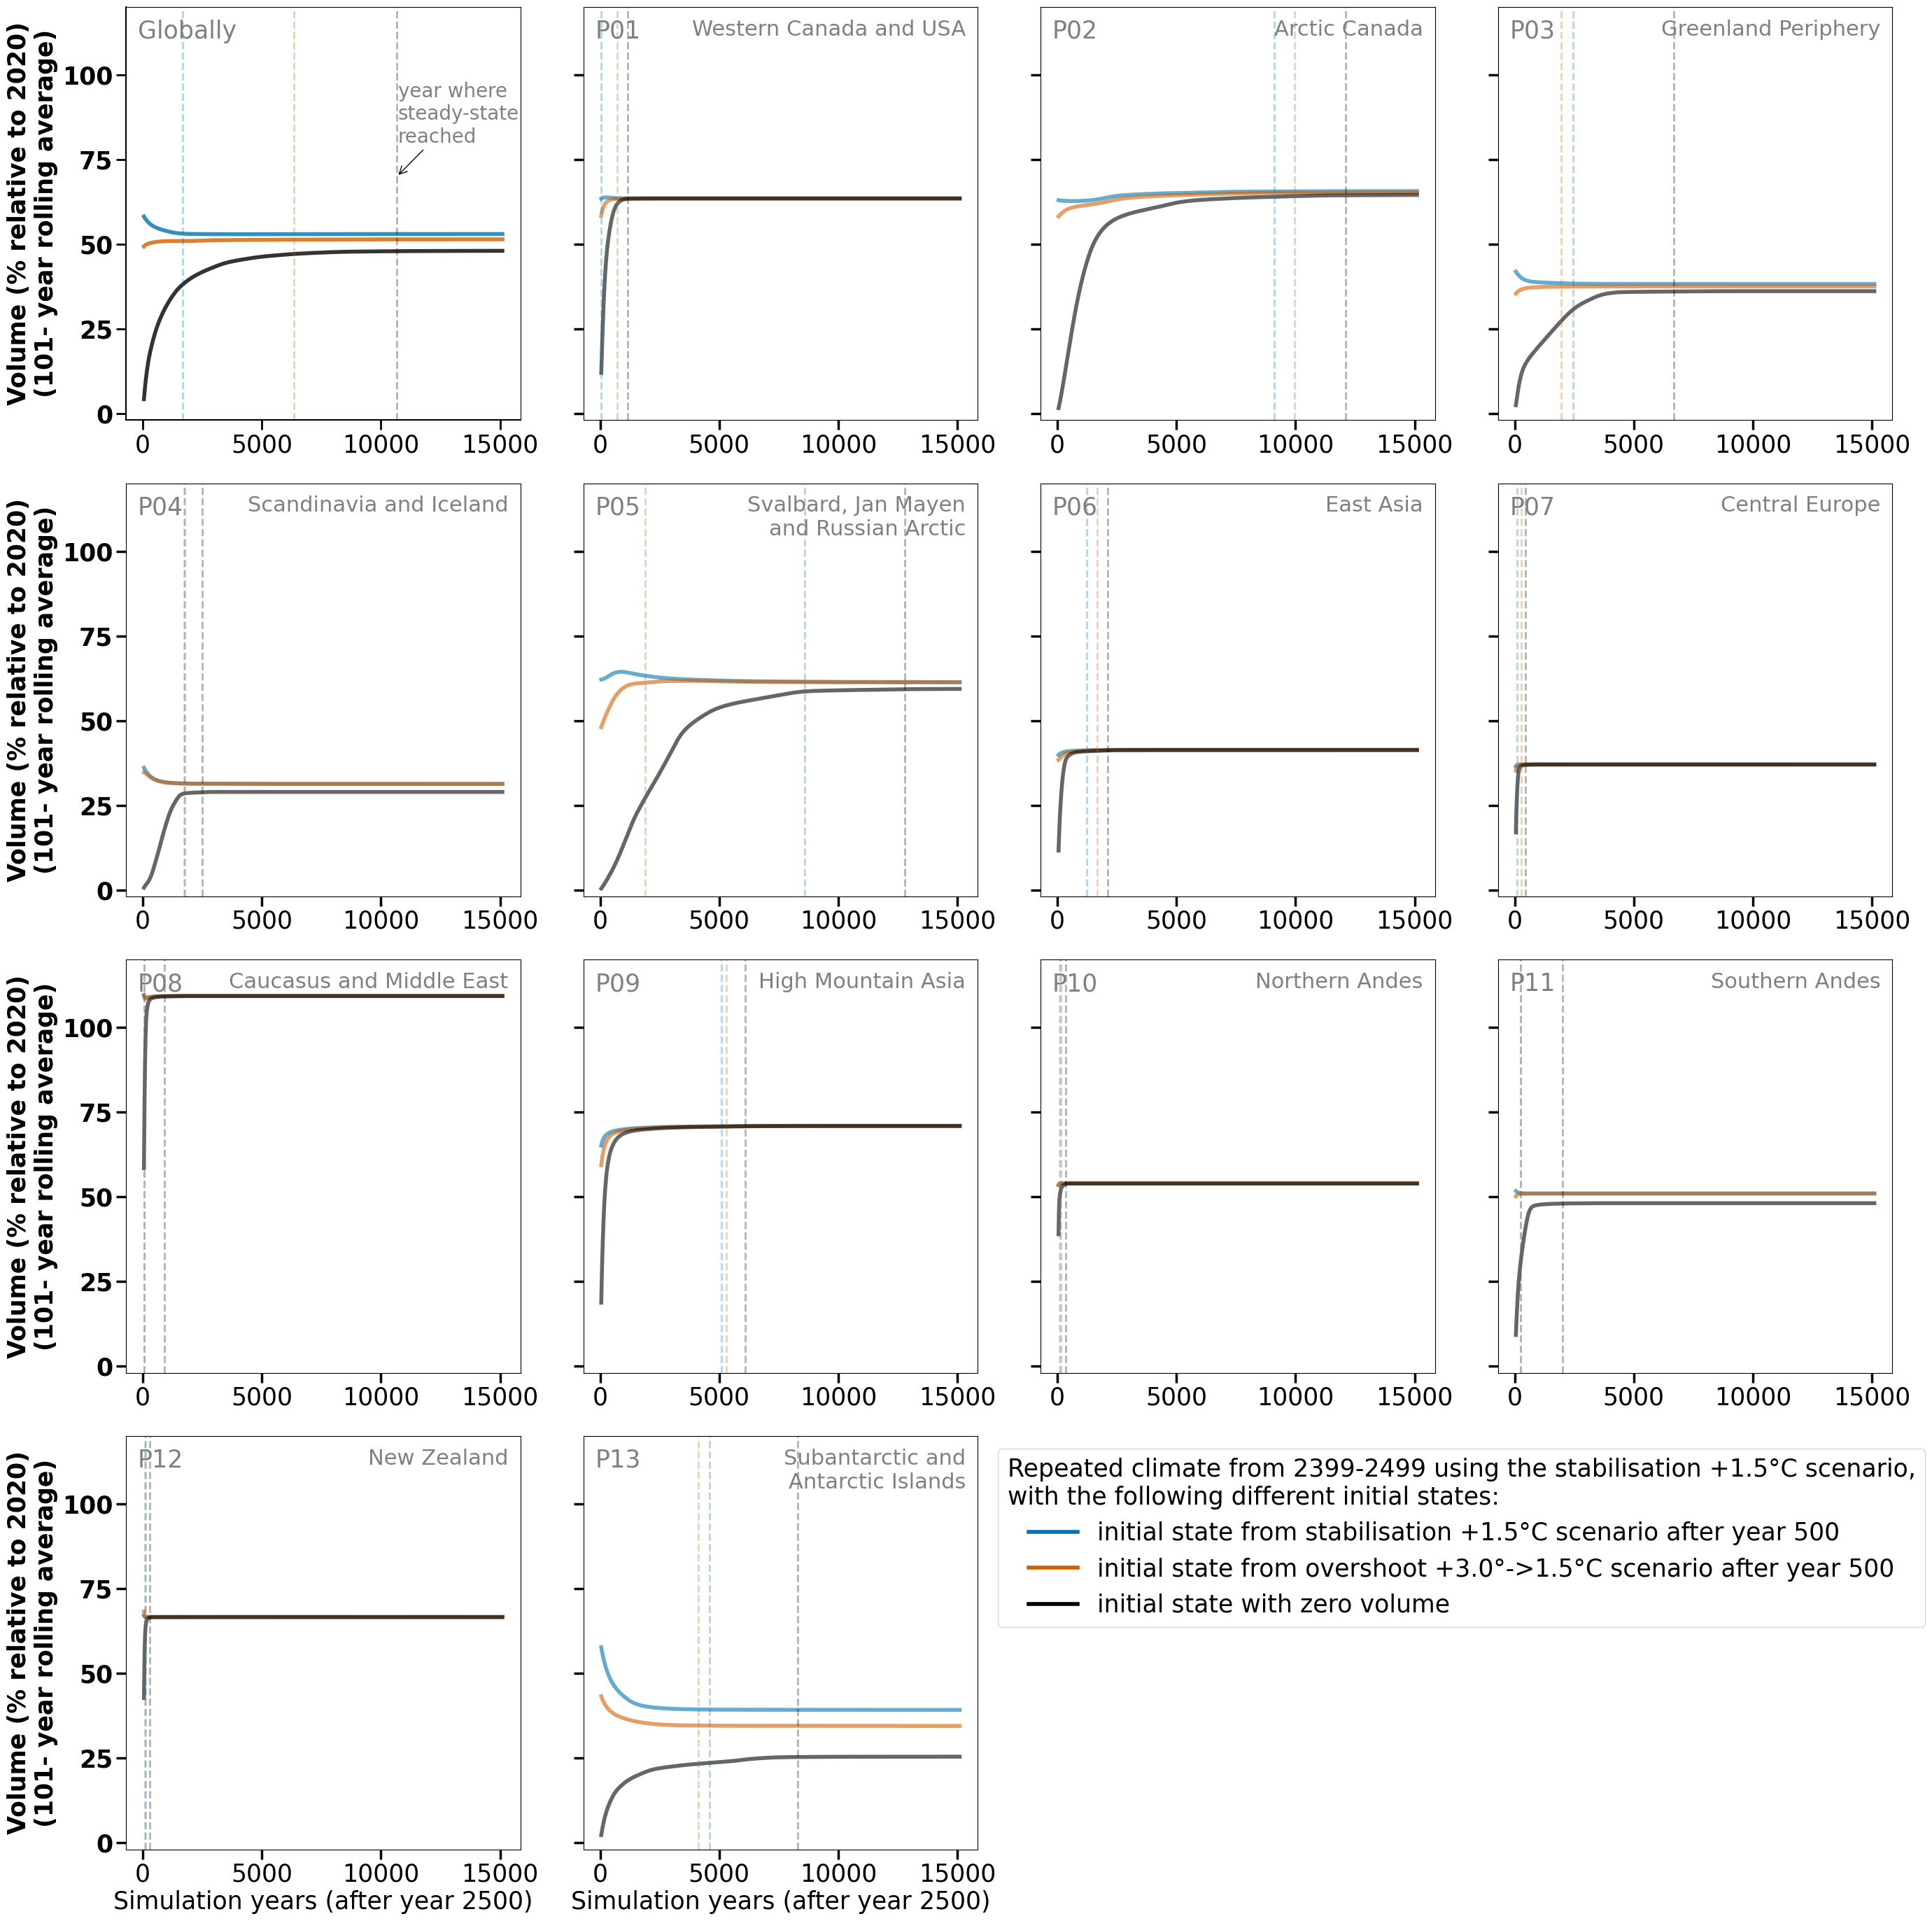

In [44]:

plt.rc('font', size=25)
portrait = True



for a,color_scenarios in zip(['_all'],
                       [color_scenario_r]):
    scenarios = color_scenarios.keys()
    paletti = list(color_scenarios.values())  
    if portrait:
        plt.figure(figsize=(28,28)) #, sharey=True, sharex=True)
        plt.subplot(4,4,1)
    else:
        plt.figure(figsize=(45,16)) #, sharey=True, sharex=True)
        plt.subplot(2,7,1)
    ax = plt.gca()
    #ax.set_title('Globally')
    plt.text(0.03,0.97, 'Globally',
             transform=ax.transAxes,ha='left',va='top',
             color='grey', fontsize=25)
    ax.set_ylabel('Volume (% relative to 2020)\n(101- year rolling average)', weight='bold')
    sns.lineplot(data=pd_vol_scenario_glob.loc[pd_vol_scenario_glob.bias_correction=='bc_1980_2019'],
                 hue='scenario', x='time', y= 'volume_rel_2020_%', 
                 palette=paletti,
                 hue_order=scenarios,lw=4, legend=False, alpha=0.8,
                 ax = ax)
    #ax.set_xlabel('Year')
    #ax.grid(axis='x')
    ax.set_ylim([-2,120]);
    ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')

    for axis in 'left', 'bottom':
        ax.spines[axis].set_linewidth(1.5)

    # set the parameters for both axis: label size in font points, the line tick line 
    # width and length in pixels
    ax.tick_params(axis='both', which='major', width=2, length=10)
    
    ax.set_xlabel('')
    #ax.set_xlim([2000,2500])
    #ax2.set_xlim([2000,2500])
    for scenario in df_scenario.scenario.values:
        plt.axvline(pd_scenario_stabilised['Globally'].loc[scenario],ls='--', alpha = 0.3, lw=2, 
                   color=color_scenario_r[scenario])
        if 'zero' in scenario:
            plt.annotate(xy=(pd_scenario_stabilised['Globally'].loc[scenario], 70),
                         xytext=(pd_scenario_stabilised['Globally'].loc[scenario]+50,80), text='year where\nsteady-state\nreached',
                         color='grey',arrowprops={'arrowstyle':'->'}, fontsize=20)

    for j, pi in enumerate(np.arange(1,14,1)):
        if pi<10:
            Preg = f'P0{pi}'
        else:
            Preg = f'P{pi}'
        if portrait:
            plt.subplot(4,4,j+2)
            x_j = np.arange(3,15,4)
            x2_j = np.arange(2,15,4)
            year_xlabel_condi = j>10

        else:
            plt.subplot(2,7,j+2)
            x_j = [6]
            x2_j = [5,12]
            year_xlabel_condi = j>5
        ax = plt.gca()
        pd_vol_scenario_rel_reg = pd_vol_scenario_rel.loc[pd_vol_scenario_rel.provide_region==Preg]
        if pi ==13:
            legend=True
        else:
            legend=False
        sns.lineplot(data=pd_vol_scenario_rel_reg.loc[pd_vol_scenario_rel_reg.bias_correction=='bc_1980_2019'],
                     hue='scenario', x='time', y= 'volume_rel_2020_%', 
                     palette=paletti,
                 hue_order=scenarios,lw=4, legend=legend, alpha =0.6, 
                 ax = ax)

        #ax.set_title(f'{Preg}')
        plt.text(0.03,0.97, Preg,
                 transform=ax.transAxes,ha='left',va='top',
                 color='grey', fontsize=25)
        plt.text(0.97,0.97, provide_reg_full_name_dict[Preg],
                 transform=ax.transAxes,ha='right',va='top',
                 color='grey', fontsize=22)
        ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')
        if j in x_j:
            ax.set_ylabel('Volume (% relative to 2020)\n(101- year rolling average)', weight='bold')
            ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], weight='bold')
        else:
            plt.ylabel('')
            ax.set_yticks(ticks=[0,25,50,75,100],
                       labels=[0,25,50,75,100], alpha=0, fontsize=1) #visible=False) 
            #plt.setp(ax.get_yticklabels(), visible=False)

        ax.set_ylim([-2,120]);
        ax.tick_params(axis='both', which='major', width=2.5, length=10)
        
        if year_xlabel_condi:
            ax.set_xlabel('Simulation years (after year 2500)')
        else:
            ax.set_xlabel('')

        #ax.set_xlim([2000,2500])
        #ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
        #ax2.set_xlim([2000,2500])
        #ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)  
        
        for scenario in df_scenario.scenario.values:
            plt.axvline(pd_scenario_stabilised[Preg].loc[scenario],ls='--', alpha = 0.3, lw=2, 
                   color=color_scenario_r[scenario])
        
        
        if pi ==13:
            han, lab = ax.get_legend_handles_labels()
            lab[0] = 'initial state from stabilisation +1.5°C scenario after year 500'
            lab[1] = 'initial state from overshoot +3.0°->1.5°C scenario after year 500'
            lab[2] = 'initial state with zero volume'
            ax.legend().remove()

    plt.tight_layout()
    leg = ax.legend(han, lab, loc = 'upper left',
                    bbox_to_anchor=(1.02,1), title='Repeated climate from 2399-2499 using the stabilisation +1.5°C scenario,\nwith the following different initial states:')
    for l in leg.get_lines():
        l.set_linewidth(4)
    #plt.savefig('test_provide_reg.png', dpi=450) #, bbox_inches='tight')
    if portrait:
        plt.savefig(f'figures/4_provide_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation.pdf')
        plt.savefig(f'figures/4_provide_reg_volume_changes_overshoot{a}_{bc}_portrait_4cols_random_climate_stabilisation.png')

    else:
        plt.savefig(f'figures/4_provide_reg_volume_changes_overshoot{a}_{bc}_random_climate_stabilisation.pdf')